# With the new control and armflapping videos (shorter directories), let's see whether we can get a higher accuracy. 

In [1]:
import cv2, os 
import numpy as np 

In [9]:
import mediapipe as mp 
from PIL import Image as im 
import mediapipe as mp


def hand_locations(frame, min_detection_confidence = 0.5, min_tracking_confidence = 0.5): 
    hands = mp.solutions.hands.Hands(min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence) # MAKE SURE THIS IS ALL GOOD 
    results = hands.process(frame.astype('uint8'))
    X_locations = [0] * 42 # use 0 as default if the class is not there 
    Y_locations = [0] * 42 
    Z_locations = [0] * 42
    x = y = z = 0 
    if results.multi_hand_landmarks:
        for hand, hand_landmark in enumerate(results.multi_hand_landmarks):
            for i in range(0, 21):
                landmark = hand_landmark.landmark[i]
                X_locations[x] = landmark.x
                Y_locations[y] = landmark.y
                Z_locations[z] = landmark.z
                x += 1; y += 1; z += 1; 
    locations = np.concatenate([X_locations, Y_locations, Z_locations])
    hands.close()
    return locations 

In [3]:
# time to actually do calibration. 

SECONDS_TO_DETECT = 2 # in seconds
DISTANCE_BETWEEN_INPUTS = 0.01 # in seconds, only matters if sampling is True
sampling = False 

import os, cv2
from tqdm import tqdm 
import numpy as np

ARMFLAPPING_VIDEOS = []
CONTROL_VIDEOS = []
ARMFLAPPING_FPS = [] # store the FPS of all armflapping videos 
CONTROL_FPS = [] # store the FPS of all control videos 
for video_name in tqdm(os.listdir('behavior_data/shorter_armflapping'), desc = "armflapping_videos"): 
    try: 
        cap = cv2.VideoCapture('behavior_data/shorter_armflapping/' + video_name)  
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        if cap.get(cv2.CAP_PROP_FRAME_COUNT) / frame_rate < SECONDS_TO_DETECT: continue # too short! 

        FRAMES = [] # frames for this video 

        while cap.isOpened(): 
            _, image = cap.read() 
            if not _ : 
                break  
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB. 
            FRAMES.append(image) 
        
        ARMFLAPPING_VIDEOS.append(FRAMES)
        ARMFLAPPING_FPS.append(frame_rate)
    except Exception as e: 
        print(f"failed on {video_name}")

for video_name in tqdm(os.listdir('behavior_data/shorter_control'), desc = "control_videos"): 
    try: 
        cap = cv2.VideoCapture('behavior_data/shorter_control/' + video_name)  
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        if cap.get(cv2.CAP_PROP_FRAME_COUNT) / frame_rate < SECONDS_TO_DETECT: continue # too short! 

        FRAMES = [] # frames for this video 

        while cap.isOpened(): 
            _, image = cap.read() 
            if not _ : 
                break 
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB. 
            FRAMES.append(image)
        
        CONTROL_VIDEOS.append(FRAMES)
        CONTROL_FPS.append(frame_rate)
    except Exception as e: 
        print(f"failed on {video_name}")
    
len(ARMFLAPPING_VIDEOS), len(CONTROL_VIDEOS)

control_videos: 100%|██████████| 63/63 [00:02<00:00, 21.44it/s]


(105, 51)

In [4]:
# get the locations of all of the videos 

ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS = [], []
for FRAMES in tqdm(ARMFLAPPING_VIDEOS) :
    locs = []
    for frame in FRAMES: 
        locs.append(hand_locations(frame))
    ARMFLAPPING_LOCATIONS.append(locs)

for FRAMES in tqdm(CONTROL_VIDEOS):  
    locs = []
    for frame in FRAMES: 
        locs.append(hand_locations(frame))
    CONTROL_LOCATIONS.append(locs)

100%|██████████| 51/51 [01:44<00:00,  2.05s/it]


In [6]:
print([len(video) for video in ARMFLAPPING_LOCATIONS])
print([len(video) for video in CONTROL_LOCATIONS])

[121, 61, 121, 90, 90, 90, 72, 72, 90, 90, 49, 49, 90, 90, 90, 72, 72, 72, 90, 121, 49, 97, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 121, 90, 90, 90, 90, 91, 90, 120, 90, 90, 121, 91, 90, 90, 90, 90, 45, 45, 121, 90, 90, 45, 90, 72, 60, 90, 90, 91, 91, 49, 91, 121, 90, 90, 72, 90, 72, 72, 49, 49, 90, 45, 72, 72, 120, 121, 90, 90, 49, 73, 72, 90, 90, 49, 72, 72, 45, 72, 91, 90, 90, 97, 49, 121, 49, 45, 72, 73, 60, 72, 90, 72]
[121, 121, 90, 90, 72, 72, 90, 91, 49, 49, 49, 61, 45, 72, 72, 72, 73, 90, 60, 121, 90, 49, 90, 90, 73, 90, 73, 49, 121, 90, 90, 90, 60, 90, 121, 90, 41, 121, 45, 60, 121, 90, 90, 90, 121, 90, 61, 46, 45, 45, 121]


In [15]:
N = min([len(locs) for locs in [ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS]])
ARMFLAPPING_LOCATIONS = ARMFLAPPING_LOCATIONS[:N]
CONTROL_LOCATIONS = CONTROL_LOCATIONS[:N]
ARMFLAPPING_LOCATIONS = np.array(ARMFLAPPING_LOCATIONS)
CONTROL_LOCATIONS = np.array(CONTROL_LOCATIONS)

NameError: name 'ARMFLAPPING_LOCATIONS' is not defined

In [16]:
# we can create a padding function in order to pad 
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 126))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)

padded_armflapping_locations = ARMFLAPPING_LOCATIONS
padded_control_locations = CONTROL_LOCATIONS
padded_armflapping_locations = pad(padded_armflapping_locations, maxlen = 90)
padded_control_locations = pad(padded_control_locations, maxlen = 90)
print(padded_control_locations.shape, padded_armflapping_locations.shape)
assert padded_armflapping_locations.shape == padded_control_locations.shape 

NameError: name 'ARMFLAPPING_LOCATIONS' is not defined

In [6]:
from sklearn.model_selection import train_test_split

def generate_data(ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS): 
    ARMFLAPPING_LABELS = np.ones(ARMFLAPPING_LOCATIONS.shape[0])
    CONTROL_LABELS = np.zeros(CONTROL_LOCATIONS.shape[0])
    
    # concatenate 
    data = np.concatenate([ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS])
    labels = np.concatenate([ARMFLAPPING_LABELS, CONTROL_LABELS])
    
    return data, labels 
X, y = generate_data(padded_armflapping_locations, padded_control_locations)

In [37]:
#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
import matplotlib.pyplot as plt 
def plot(history, show_pr = False, num = None): 
    
    if num: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision_{num}'], label = "train_precision")
            plt.plot(history.history[f'val_precision_{num}'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall_{num}'], label = "train_recall")
            plt.plot(history.history[f'val_recall_{num}'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    else: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision'], label = "train_precision")
            plt.plot(history.history[f'val_precision'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall'], label = "train_recall")
            plt.plot(history.history[f'val_recall'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    # let's see whether it can detect me not doing anything 

def predict_on_video(model, path): 
    test_frames = []
    import cv2 

    cap = cv2.VideoCapture(path)

    while True: 
        _, frame = cap.read() 
        if not _: break 

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = hand_locations(frame)

        test_frames.append(frame)

    test_frames = np.array([test_frames])
    test_frames = pad(test_frames, maxlen = 90)
    
    return model.predict(test_frames)

In [11]:
import random 
import tensorflow as tf 
tf.config.run_functions_eagerly(True)

def _shift(X):
        
        X = tf.Variable(X, dtype = tf.float32)
        
        X_locations = X[:, :42] # [100, 42]
        Y_locations = X[:, 42:84] # [100, 42]
        Z_locations = X[:, 84:] # [100, 42]
        
        maximum = tf.math.reduce_max(Y_locations)
        minimum = tf.math.reduce_min(Y_locations)
        if maximum == 2: 
            # get the second highest 
            values, _ = tf.nn.top_k(tf.reshape(Y_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e: 
                maximum = 0 
            
        can_move_up = 1 - maximum # the amount it can move up 
        can_move_down = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            #print("up")
            # move up in this case 
            move_up = tf.random.uniform((1,), 0, can_move_up)
            X[:, 42:84].assign(X[:,42:84] + move_up)

        else: 
            move_down = tf.random.uniform((1,), 0, can_move_down)
            X[:, 42:84].assign(X[:,42:84]-move_down)

        maximum = tf.math.reduce_max(X_locations)
        minimum = tf.math.reduce_min(X_locations)
        
        if maximum == 2: 
            values, _ = tf.nn.top_k(tf.reshape(X_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            # create a set. 
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e: 
                maximum = 0 
            
        can_move_right = 1 - maximum 
        can_move_left = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            #print("right")
            # move right
            move_right = tf.random.uniform((1,), 0, can_move_right)
            X[:, :42].assign(X[:,:42]+move_right)
        else: 
            # move left 
            move_left = tf.random.uniform((1,), 0, can_move_left)
            X[:, :42].assign(X[:,:42]-move_left)

        
        maximum = tf.math.reduce_max(Z_locations)
        minimum = tf.math.reduce_min(Z_locations)
        if maximum == 2: 
            values, _ = tf.nn.top_k(tf.reshape(Z_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e:  
                maximum = 0 
        
        can_move_far = 1 - maximum 
        can_move_close = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            # move right
            move_far = tf.random.uniform((1,), 0, can_move_far)
            X[:, 84:].assign(X[:,84:]+move_far)
        else: 
            # move left 
            move_close = tf.random.uniform((1,), 0, can_move_close)
            X[:, 84:].assign(X[:,84:]-move_close)

        return X


class Augmenter(tf.keras.layers.Layer): 
    def __init__(self): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        
    def call(self, X, training = True):
        if training: 
            X =  tf.map_fn(_shift, X)
            return X
        else: 
            return X 

class TTAugmenter(tf.keras.layers.Layer): 
    def __init__(self): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        
    def call(self, X):
        return tf.map_fn(_shift, X)
        
        

# Below we'll try various tensorflow random states on various different models. 

using seed 0
On the 0th model
Epoch 1/30
3/3 [==============================] - 2s 751ms/step - loss: 0.6772 - accuracy: 0.6173 - val_loss: 0.8227 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 298ms/step - loss: 0.6354 - accuracy: 0.6296 - val_loss: 0.9430 - val_accuracy: 0.0952
Epoch 3/30
3/3 [==============================] - 1s 305ms/step - loss: 0.5932 - accuracy: 0.6667 - val_loss: 1.0107 - val_accuracy: 0.1905
Epoch 4/30
3/3 [==============================] - 1s 291ms/step - loss: 0.5482 - accuracy: 0.6790 - val_loss: 1.1713 - val_accuracy: 0.1905
Epoch 5/30
3/3 [==============================] - 1s 311ms/step - loss: 0.5491 - accuracy: 0.7037 - val_loss: 1.1244 - val_accuracy: 0.1905
Epoch 6/30
3/3 [==============================] - 1s 295ms/step - loss: 0.5054 - accuracy: 0.6914 - val_loss: 1.2542 - val_accuracy: 0.1905
Epoch 7/30
3/3 [==============================] - 1s 331ms/step - loss: 0.5059 - accuracy: 0.7160 - val_loss: 1.2674 - val_acc

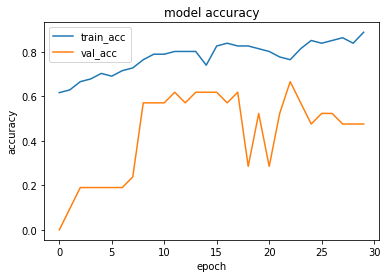

On the 1th model
Epoch 1/30
3/3 [==============================] - 2s 481ms/step - loss: 0.6733 - accuracy: 0.6296 - val_loss: 0.8749 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 287ms/step - loss: 0.6331 - accuracy: 0.6296 - val_loss: 1.0402 - val_accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 1s 281ms/step - loss: 0.5857 - accuracy: 0.6667 - val_loss: 0.9447 - val_accuracy: 0.1905
Epoch 4/30
3/3 [==============================] - 1s 289ms/step - loss: 0.5407 - accuracy: 0.6914 - val_loss: 1.2010 - val_accuracy: 0.1905
Epoch 5/30
3/3 [==============================] - 1s 282ms/step - loss: 0.5423 - accuracy: 0.6914 - val_loss: 1.2414 - val_accuracy: 0.1905
Epoch 6/30
3/3 [==============================] - 1s 299ms/step - loss: 0.4992 - accuracy: 0.7284 - val_loss: 1.3976 - val_accuracy: 0.1905
Epoch 7/30
3/3 [==============================] - 1s 278ms/step - loss: 0.4998 - accuracy: 0.7407 - val_loss: 1.3428 - val_accuracy: 0.

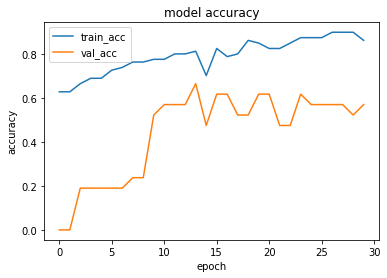

On the 2th model
Epoch 1/30
3/3 [==============================] - 1s 451ms/step - loss: 0.6604 - accuracy: 0.6296 - val_loss: 0.8790 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 471ms/step - loss: 0.6980 - accuracy: 0.6296 - val_loss: 0.9022 - val_accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 1s 445ms/step - loss: 0.6501 - accuracy: 0.6296 - val_loss: 0.8263 - val_accuracy: 0.0952
Epoch 4/30
3/3 [==============================] - 1s 487ms/step - loss: 0.6424 - accuracy: 0.6543 - val_loss: 0.8827 - val_accuracy: 0.0952
Epoch 5/30
3/3 [==============================] - 1s 453ms/step - loss: 0.6209 - accuracy: 0.6420 - val_loss: 1.0605 - val_accuracy: 0.0000e+00
Epoch 6/30
3/3 [==============================] - 2s 720ms/step - loss: 0.5689 - accuracy: 0.7284 - val_loss: 1.0490 - val_accuracy: 0.1905
Epoch 7/30
3/3 [==============================] - 1s 442ms/step - loss: 0.5586 - accuracy: 0.6790 - val_loss: 1.0615 - val_accuracy

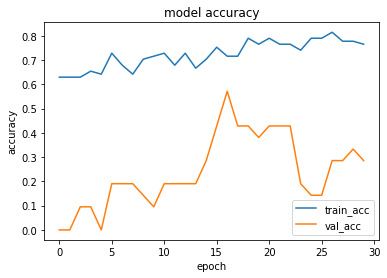

On the 3th model
Epoch 1/30
3/3 [==============================] - 1s 419ms/step - loss: 0.6570 - accuracy: 0.6790 - val_loss: 0.9295 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 439ms/step - loss: 0.6268 - accuracy: 0.6543 - val_loss: 0.9687 - val_accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 2s 712ms/step - loss: 0.6546 - accuracy: 0.6790 - val_loss: 0.8392 - val_accuracy: 0.0952
Epoch 4/30
3/3 [==============================] - 1s 403ms/step - loss: 0.6401 - accuracy: 0.6914 - val_loss: 0.8342 - val_accuracy: 0.0952
Epoch 5/30
3/3 [==============================] - 1s 433ms/step - loss: 0.6124 - accuracy: 0.6296 - val_loss: 0.9092 - val_accuracy: 0.0952
Epoch 6/30
3/3 [==============================] - 1s 421ms/step - loss: 0.5801 - accuracy: 0.6790 - val_loss: 0.9653 - val_accuracy: 0.1905
Epoch 7/30
3/3 [==============================] - 1s 443ms/step - loss: 0.5938 - accuracy: 0.6667 - val_loss: 1.0086 - val_accuracy: 0.

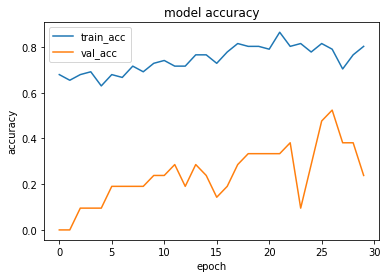

using seed 1
On the 0th model
Epoch 1/30
3/3 [==============================] - 2s 499ms/step - loss: 0.6820 - accuracy: 0.6173 - val_loss: 0.8505 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 305ms/step - loss: 0.6484 - accuracy: 0.6296 - val_loss: 0.9036 - val_accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 1s 292ms/step - loss: 0.6171 - accuracy: 0.6296 - val_loss: 0.8946 - val_accuracy: 0.0952
Epoch 4/30
3/3 [==============================] - 1s 283ms/step - loss: 0.5843 - accuracy: 0.6420 - val_loss: 1.1030 - val_accuracy: 0.1429
Epoch 5/30
3/3 [==============================] - 1s 277ms/step - loss: 0.5947 - accuracy: 0.6667 - val_loss: 1.1729 - val_accuracy: 0.1905
Epoch 6/30
3/3 [==============================] - 1s 279ms/step - loss: 0.5477 - accuracy: 0.7037 - val_loss: 0.9271 - val_accuracy: 0.2381
Epoch 7/30
3/3 [==============================] - 1s 288ms/step - loss: 0.5263 - accuracy: 0.7160 - val_loss: 1.0351 - val

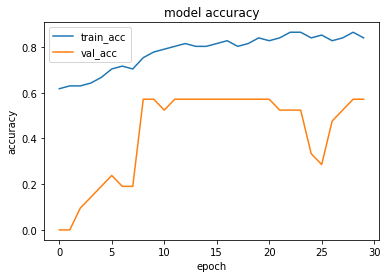

On the 1th model
Epoch 1/30
3/3 [==============================] - 2s 507ms/step - loss: 0.6885 - accuracy: 0.5185 - val_loss: 0.9263 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 290ms/step - loss: 0.6465 - accuracy: 0.6296 - val_loss: 0.8834 - val_accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 1s 296ms/step - loss: 0.6282 - accuracy: 0.6296 - val_loss: 0.8270 - val_accuracy: 0.0952
Epoch 4/30
3/3 [==============================] - 1s 296ms/step - loss: 0.6080 - accuracy: 0.6543 - val_loss: 0.9270 - val_accuracy: 0.0952
Epoch 5/30
3/3 [==============================] - 1s 341ms/step - loss: 0.5845 - accuracy: 0.6543 - val_loss: 1.1273 - val_accuracy: 0.0952
Epoch 6/30
3/3 [==============================] - 1s 300ms/step - loss: 0.5603 - accuracy: 0.6667 - val_loss: 1.0223 - val_accuracy: 0.1905
Epoch 7/30
3/3 [==============================] - 1s 295ms/step - loss: 0.5270 - accuracy: 0.6914 - val_loss: 1.0202 - val_accuracy: 0.

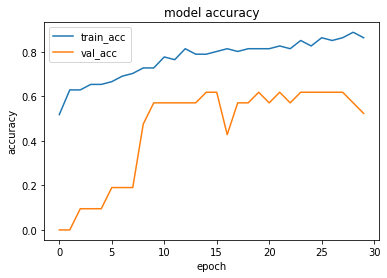

On the 2th model
Epoch 1/30
3/3 [==============================] - 1s 418ms/step - loss: 0.6915 - accuracy: 0.6420 - val_loss: 0.8376 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 421ms/step - loss: 0.6534 - accuracy: 0.6296 - val_loss: 0.7893 - val_accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 1s 404ms/step - loss: 0.6384 - accuracy: 0.6790 - val_loss: 0.7671 - val_accuracy: 0.1429
Epoch 4/30
3/3 [==============================] - 1s 440ms/step - loss: 0.6162 - accuracy: 0.6914 - val_loss: 0.8345 - val_accuracy: 0.0952
Epoch 5/30
3/3 [==============================] - 1s 409ms/step - loss: 0.6462 - accuracy: 0.6420 - val_loss: 0.9279 - val_accuracy: 0.0952
Epoch 6/30
3/3 [==============================] - 2s 691ms/step - loss: 0.5894 - accuracy: 0.6543 - val_loss: 0.9580 - val_accuracy: 0.1429
Epoch 7/30
3/3 [==============================] - 1s 434ms/step - loss: 0.5594 - accuracy: 0.7407 - val_loss: 1.0324 - val_accuracy: 0.

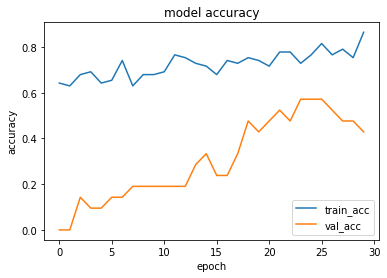

On the 3th model
Epoch 1/30
3/3 [==============================] - 1s 430ms/step - loss: 0.7133 - accuracy: 0.4568 - val_loss: 0.8094 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 430ms/step - loss: 0.6449 - accuracy: 0.6296 - val_loss: 0.8296 - val_accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 2s 706ms/step - loss: 0.6382 - accuracy: 0.6296 - val_loss: 0.8266 - val_accuracy: 0.0000e+00
Epoch 4/30
3/3 [==============================] - 1s 435ms/step - loss: 0.6024 - accuracy: 0.6543 - val_loss: 0.8606 - val_accuracy: 0.0952
Epoch 5/30
3/3 [==============================] - 1s 423ms/step - loss: 0.6100 - accuracy: 0.6914 - val_loss: 0.9676 - val_accuracy: 0.1429
Epoch 6/30
3/3 [==============================] - 1s 410ms/step - loss: 0.5967 - accuracy: 0.6543 - val_loss: 0.9587 - val_accuracy: 0.1905
Epoch 7/30
3/3 [==============================] - 1s 417ms/step - loss: 0.5715 - accuracy: 0.6790 - val_loss: 1.0458 - val_accuracy

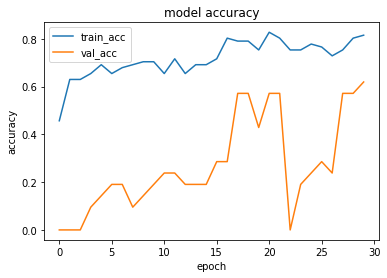

using seed 13
On the 0th model
Epoch 1/30
3/3 [==============================] - 2s 496ms/step - loss: 0.6823 - accuracy: 0.6543 - val_loss: 0.8520 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 304ms/step - loss: 0.6392 - accuracy: 0.6296 - val_loss: 1.0386 - val_accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 1s 297ms/step - loss: 0.6026 - accuracy: 0.6296 - val_loss: 0.9933 - val_accuracy: 0.0952
Epoch 4/30
3/3 [==============================] - 1s 283ms/step - loss: 0.5677 - accuracy: 0.6790 - val_loss: 0.9833 - val_accuracy: 0.1905
Epoch 5/30
3/3 [==============================] - 1s 280ms/step - loss: 0.5295 - accuracy: 0.7160 - val_loss: 1.3741 - val_accuracy: 0.1905
Epoch 6/30
3/3 [==============================] - 1s 305ms/step - loss: 0.5715 - accuracy: 0.6914 - val_loss: 1.2029 - val_accuracy: 0.2381
Epoch 7/30
3/3 [==============================] - 1s 283ms/step - loss: 0.4836 - accuracy: 0.7284 - val_loss: 1.1023 - va

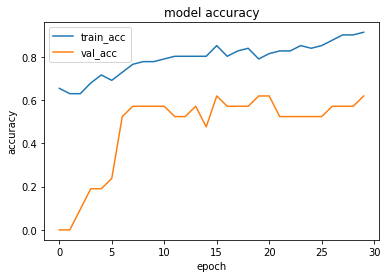

On the 1th model
Epoch 1/30
3/3 [==============================] - 2s 505ms/step - loss: 0.6697 - accuracy: 0.6790 - val_loss: 0.9281 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 303ms/step - loss: 0.6196 - accuracy: 0.6296 - val_loss: 1.0279 - val_accuracy: 0.0952
Epoch 3/30
3/3 [==============================] - 1s 320ms/step - loss: 0.5614 - accuracy: 0.6790 - val_loss: 1.0858 - val_accuracy: 0.1905
Epoch 4/30
3/3 [==============================] - 1s 313ms/step - loss: 0.5441 - accuracy: 0.6914 - val_loss: 1.2645 - val_accuracy: 0.1905
Epoch 5/30
3/3 [==============================] - 1s 324ms/step - loss: 0.5623 - accuracy: 0.7160 - val_loss: 1.0152 - val_accuracy: 0.1905
Epoch 6/30
3/3 [==============================] - 1s 317ms/step - loss: 0.5050 - accuracy: 0.7284 - val_loss: 1.2765 - val_accuracy: 0.1905
Epoch 7/30
3/3 [==============================] - 1s 310ms/step - loss: 0.5055 - accuracy: 0.6914 - val_loss: 1.4345 - val_accuracy: 0.0952

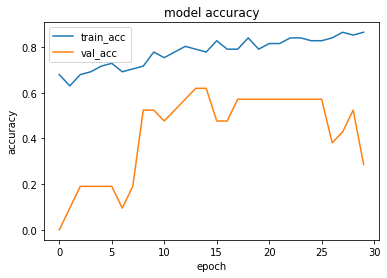

On the 2th model
Epoch 1/30
3/3 [==============================] - 1s 466ms/step - loss: 0.6616 - accuracy: 0.6173 - val_loss: 0.8636 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 470ms/step - loss: 0.6647 - accuracy: 0.6296 - val_loss: 0.8119 - val_accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 1s 473ms/step - loss: 0.6362 - accuracy: 0.6420 - val_loss: 0.7732 - val_accuracy: 0.0952
Epoch 4/30
3/3 [==============================] - 1s 473ms/step - loss: 0.6274 - accuracy: 0.6543 - val_loss: 0.8408 - val_accuracy: 0.0952
Epoch 5/30
3/3 [==============================] - 1s 449ms/step - loss: 0.6079 - accuracy: 0.6420 - val_loss: 0.9987 - val_accuracy: 0.0952
Epoch 6/30
3/3 [==============================] - 2s 684ms/step - loss: 0.6017 - accuracy: 0.6790 - val_loss: 0.9855 - val_accuracy: 0.1429
Epoch 7/30
3/3 [==============================] - 1s 414ms/step - loss: 0.5646 - accuracy: 0.7160 - val_loss: 1.0091 - val_accuracy: 0.

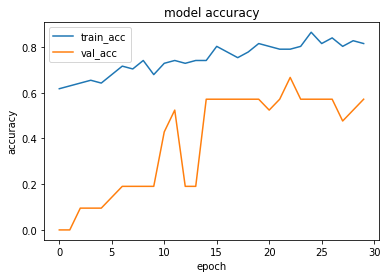

On the 3th model
Epoch 1/30
3/3 [==============================] - 1s 485ms/step - loss: 0.6755 - accuracy: 0.5556 - val_loss: 0.8694 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 463ms/step - loss: 0.6398 - accuracy: 0.6296 - val_loss: 0.8399 - val_accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 2s 733ms/step - loss: 0.6350 - accuracy: 0.6296 - val_loss: 0.8148 - val_accuracy: 0.0952
Epoch 4/30
3/3 [==============================] - 1s 466ms/step - loss: 0.6127 - accuracy: 0.6543 - val_loss: 0.8224 - val_accuracy: 0.1429
Epoch 5/30
3/3 [==============================] - 1s 466ms/step - loss: 0.6244 - accuracy: 0.6543 - val_loss: 0.8839 - val_accuracy: 0.1905
Epoch 6/30
3/3 [==============================] - 1s 464ms/step - loss: 0.5854 - accuracy: 0.6914 - val_loss: 0.7622 - val_accuracy: 0.5714
Epoch 7/30
3/3 [==============================] - 1s 439ms/step - loss: 0.5945 - accuracy: 0.6914 - val_loss: 0.8627 - val_accuracy: 0.

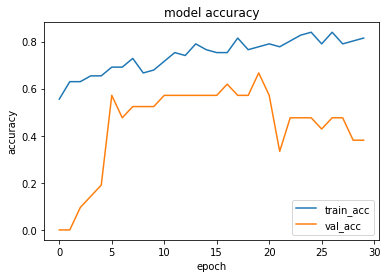

using seed 42
On the 0th model
Epoch 1/30
3/3 [==============================] - 1s 425ms/step - loss: 0.6843 - accuracy: 0.5185 - val_loss: 0.8560 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 279ms/step - loss: 0.6354 - accuracy: 0.6296 - val_loss: 0.9981 - val_accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 1s 282ms/step - loss: 0.6130 - accuracy: 0.6296 - val_loss: 1.0424 - val_accuracy: 0.0952
Epoch 4/30
3/3 [==============================] - 1s 279ms/step - loss: 0.5547 - accuracy: 0.6914 - val_loss: 0.9121 - val_accuracy: 0.2381
Epoch 5/30
3/3 [==============================] - 1s 291ms/step - loss: 0.5512 - accuracy: 0.7160 - val_loss: 1.1745 - val_accuracy: 0.1905
Epoch 6/30
3/3 [==============================] - 1s 301ms/step - loss: 0.5244 - accuracy: 0.7160 - val_loss: 1.0589 - val_accuracy: 0.1905
Epoch 7/30
3/3 [==============================] - 1s 310ms/step - loss: 0.5008 - accuracy: 0.7284 - val_loss: 1.1445 - va

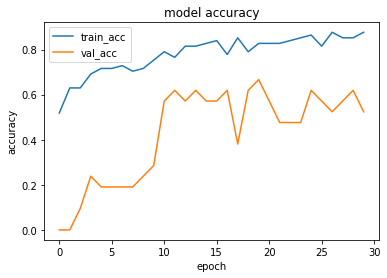

On the 1th model
Epoch 1/30
3/3 [==============================] - 2s 478ms/step - loss: 0.6738 - accuracy: 0.5802 - val_loss: 0.9678 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 325ms/step - loss: 0.6252 - accuracy: 0.6296 - val_loss: 1.0082 - val_accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 1s 351ms/step - loss: 0.5956 - accuracy: 0.6296 - val_loss: 1.0416 - val_accuracy: 0.1429
Epoch 4/30
3/3 [==============================] - 1s 302ms/step - loss: 0.5568 - accuracy: 0.6790 - val_loss: 0.9826 - val_accuracy: 0.1905
Epoch 5/30
3/3 [==============================] - 1s 340ms/step - loss: 0.5458 - accuracy: 0.7037 - val_loss: 1.1481 - val_accuracy: 0.1905
Epoch 6/30
3/3 [==============================] - 1s 312ms/step - loss: 0.5372 - accuracy: 0.7160 - val_loss: 0.9521 - val_accuracy: 0.2381
Epoch 7/30
3/3 [==============================] - 1s 333ms/step - loss: 0.5041 - accuracy: 0.7160 - val_loss: 1.0438 - val_accuracy: 0.

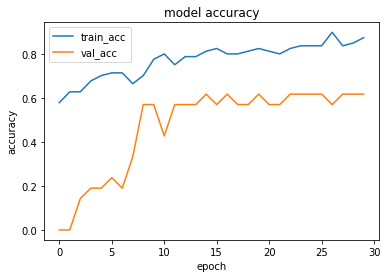

On the 2th model
Epoch 1/30
3/3 [==============================] - 1s 423ms/step - loss: 0.6499 - accuracy: 0.6296 - val_loss: 0.8778 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 471ms/step - loss: 0.6095 - accuracy: 0.6296 - val_loss: 0.7476 - val_accuracy: 0.0952
Epoch 3/30
3/3 [==============================] - 1s 429ms/step - loss: 0.7053 - accuracy: 0.6420 - val_loss: 0.7424 - val_accuracy: 0.1429
Epoch 4/30
3/3 [==============================] - 1s 478ms/step - loss: 0.6407 - accuracy: 0.6667 - val_loss: 0.7406 - val_accuracy: 0.6190
Epoch 5/30
3/3 [==============================] - 1s 435ms/step - loss: 0.6395 - accuracy: 0.6667 - val_loss: 0.8266 - val_accuracy: 0.1429
Epoch 6/30
3/3 [==============================] - 2s 690ms/step - loss: 0.6112 - accuracy: 0.7037 - val_loss: 0.9863 - val_accuracy: 0.0952
Epoch 7/30
3/3 [==============================] - 1s 428ms/step - loss: 0.6053 - accuracy: 0.6049 - val_loss: 1.0274 - val_accuracy: 0.1429

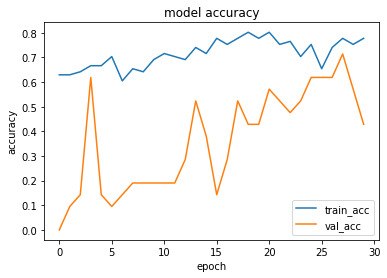

On the 3th model
Epoch 1/30
3/3 [==============================] - 1s 478ms/step - loss: 0.6759 - accuracy: 0.5802 - val_loss: 0.8376 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 444ms/step - loss: 0.6360 - accuracy: 0.6296 - val_loss: 0.8153 - val_accuracy: 0.0952
Epoch 3/30
3/3 [==============================] - 2s 715ms/step - loss: 0.6268 - accuracy: 0.6296 - val_loss: 0.9331 - val_accuracy: 0.0000e+00
Epoch 4/30
3/3 [==============================] - 1s 476ms/step - loss: 0.6036 - accuracy: 0.6296 - val_loss: 0.9737 - val_accuracy: 0.1429
Epoch 5/30
3/3 [==============================] - 1s 408ms/step - loss: 0.5778 - accuracy: 0.6914 - val_loss: 1.0193 - val_accuracy: 0.1905
Epoch 6/30
3/3 [==============================] - 1s 496ms/step - loss: 0.5481 - accuracy: 0.7037 - val_loss: 1.0169 - val_accuracy: 0.1905
Epoch 7/30
3/3 [==============================] - 1s 483ms/step - loss: 0.5136 - accuracy: 0.6914 - val_loss: 1.2170 - val_accuracy: 0.

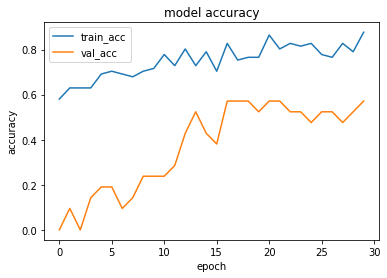

using seed 69
On the 0th model
Epoch 1/30
3/3 [==============================] - 1s 444ms/step - loss: 0.6769 - accuracy: 0.6296 - val_loss: 0.9049 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 291ms/step - loss: 0.6365 - accuracy: 0.6296 - val_loss: 0.9838 - val_accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 1s 323ms/step - loss: 0.5990 - accuracy: 0.6420 - val_loss: 1.0729 - val_accuracy: 0.0952
Epoch 4/30
3/3 [==============================] - 1s 297ms/step - loss: 0.5554 - accuracy: 0.6790 - val_loss: 1.1111 - val_accuracy: 0.1905
Epoch 5/30
3/3 [==============================] - 1s 332ms/step - loss: 0.5490 - accuracy: 0.6914 - val_loss: 1.3293 - val_accuracy: 0.1905
Epoch 6/30
3/3 [==============================] - 1s 295ms/step - loss: 0.5449 - accuracy: 0.6914 - val_loss: 1.3743 - val_accuracy: 0.2381
Epoch 7/30
3/3 [==============================] - 1s 299ms/step - loss: 0.4964 - accuracy: 0.7160 - val_loss: 1.0174 - va

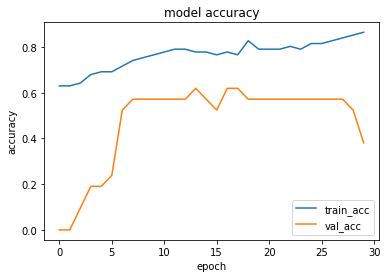

On the 1th model
Epoch 1/30
3/3 [==============================] - 1s 456ms/step - loss: 0.6993 - accuracy: 0.4691 - val_loss: 0.9007 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 312ms/step - loss: 0.6392 - accuracy: 0.6296 - val_loss: 1.0398 - val_accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 1s 294ms/step - loss: 0.6032 - accuracy: 0.6296 - val_loss: 1.0229 - val_accuracy: 0.0952
Epoch 4/30
3/3 [==============================] - 1s 296ms/step - loss: 0.5665 - accuracy: 0.6790 - val_loss: 0.9917 - val_accuracy: 0.1905
Epoch 5/30
3/3 [==============================] - 1s 295ms/step - loss: 0.5421 - accuracy: 0.7037 - val_loss: 1.2117 - val_accuracy: 0.1905
Epoch 6/30
3/3 [==============================] - 1s 295ms/step - loss: 0.5598 - accuracy: 0.6790 - val_loss: 1.3388 - val_accuracy: 0.1905
Epoch 7/30
3/3 [==============================] - 1s 300ms/step - loss: 0.5337 - accuracy: 0.6914 - val_loss: 1.0339 - val_accuracy: 0.

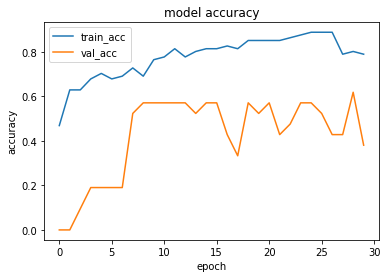

On the 2th model
Epoch 1/30
3/3 [==============================] - 1s 447ms/step - loss: 0.6871 - accuracy: 0.6049 - val_loss: 0.7968 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 483ms/step - loss: 0.6467 - accuracy: 0.6296 - val_loss: 0.7652 - val_accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 1s 474ms/step - loss: 0.6662 - accuracy: 0.6296 - val_loss: 0.7856 - val_accuracy: 0.0000e+00
Epoch 4/30
3/3 [==============================] - 1s 451ms/step - loss: 0.6413 - accuracy: 0.6296 - val_loss: 0.8197 - val_accuracy: 0.0000e+00
Epoch 5/30
3/3 [==============================] - 1s 413ms/step - loss: 0.6420 - accuracy: 0.6296 - val_loss: 0.8681 - val_accuracy: 0.0000e+00
Epoch 6/30
3/3 [==============================] - 2s 664ms/step - loss: 0.6198 - accuracy: 0.6543 - val_loss: 0.9565 - val_accuracy: 0.0952
Epoch 7/30
3/3 [==============================] - 1s 454ms/step - loss: 0.5881 - accuracy: 0.6543 - val_loss: 0.8993 - val_

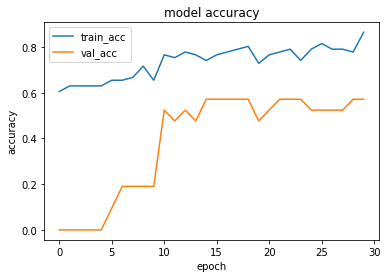

On the 3th model
Epoch 1/30
3/3 [==============================] - 1s 443ms/step - loss: 0.6821 - accuracy: 0.6420 - val_loss: 0.8624 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 440ms/step - loss: 0.6399 - accuracy: 0.6420 - val_loss: 0.8499 - val_accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 2s 712ms/step - loss: 0.6136 - accuracy: 0.6790 - val_loss: 0.9132 - val_accuracy: 0.0952
Epoch 4/30
3/3 [==============================] - 1s 450ms/step - loss: 0.6193 - accuracy: 0.6420 - val_loss: 1.1235 - val_accuracy: 0.0952
Epoch 5/30
3/3 [==============================] - 1s 447ms/step - loss: 0.5686 - accuracy: 0.6543 - val_loss: 1.1538 - val_accuracy: 0.1905
Epoch 6/30
3/3 [==============================] - 1s 454ms/step - loss: 0.5391 - accuracy: 0.7160 - val_loss: 1.2369 - val_accuracy: 0.1905
Epoch 7/30
3/3 [==============================] - 1s 434ms/step - loss: 0.5488 - accuracy: 0.7037 - val_loss: 1.1083 - val_accuracy: 0.

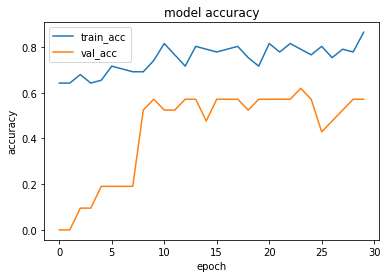

using seed 100
On the 0th model
Epoch 1/30
3/3 [==============================] - 2s 474ms/step - loss: 0.6647 - accuracy: 0.6296 - val_loss: 0.8776 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 327ms/step - loss: 0.6084 - accuracy: 0.6296 - val_loss: 0.9753 - val_accuracy: 0.1429
Epoch 3/30
3/3 [==============================] - 1s 326ms/step - loss: 0.5460 - accuracy: 0.7037 - val_loss: 0.7559 - val_accuracy: 0.2857
Epoch 4/30
3/3 [==============================] - 1s 312ms/step - loss: 0.5796 - accuracy: 0.7284 - val_loss: 1.2680 - val_accuracy: 0.1905
Epoch 5/30
3/3 [==============================] - 1s 297ms/step - loss: 0.5151 - accuracy: 0.6914 - val_loss: 1.0911 - val_accuracy: 0.1905
Epoch 6/30
3/3 [==============================] - 1s 285ms/step - loss: 0.4941 - accuracy: 0.7037 - val_loss: 1.0195 - val_accuracy: 0.2857
Epoch 7/30
3/3 [==============================] - 1s 301ms/step - loss: 0.4848 - accuracy: 0.7407 - val_loss: 1.1330 - val_a

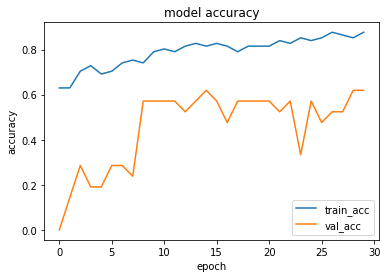

On the 1th model
Epoch 1/30
3/3 [==============================] - 2s 476ms/step - loss: 0.6759 - accuracy: 0.6420 - val_loss: 0.8707 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 319ms/step - loss: 0.6321 - accuracy: 0.6296 - val_loss: 1.1076 - val_accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 1s 297ms/step - loss: 0.6121 - accuracy: 0.6296 - val_loss: 1.0460 - val_accuracy: 0.0952
Epoch 4/30
3/3 [==============================] - 1s 301ms/step - loss: 0.5519 - accuracy: 0.7037 - val_loss: 0.7869 - val_accuracy: 0.2381
Epoch 5/30
3/3 [==============================] - 1s 284ms/step - loss: 0.5622 - accuracy: 0.6790 - val_loss: 1.1180 - val_accuracy: 0.1905
Epoch 6/30
3/3 [==============================] - 1s 289ms/step - loss: 0.5302 - accuracy: 0.7037 - val_loss: 1.1946 - val_accuracy: 0.1905
Epoch 7/30
3/3 [==============================] - 1s 288ms/step - loss: 0.5104 - accuracy: 0.7037 - val_loss: 0.9729 - val_accuracy: 0.

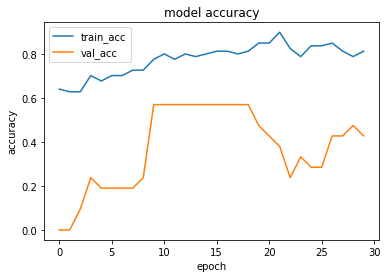

On the 2th model
Epoch 1/30
3/3 [==============================] - 1s 453ms/step - loss: 0.6659 - accuracy: 0.5432 - val_loss: 0.8915 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 424ms/step - loss: 0.6590 - accuracy: 0.6296 - val_loss: 0.9042 - val_accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 1s 418ms/step - loss: 0.6599 - accuracy: 0.6296 - val_loss: 0.8194 - val_accuracy: 0.0952
Epoch 4/30
3/3 [==============================] - 1s 423ms/step - loss: 0.6134 - accuracy: 0.7037 - val_loss: 0.7733 - val_accuracy: 0.1905
Epoch 5/30
3/3 [==============================] - 1s 415ms/step - loss: 0.6009 - accuracy: 0.6914 - val_loss: 0.8817 - val_accuracy: 0.1905
Epoch 6/30
3/3 [==============================] - 2s 682ms/step - loss: 0.5920 - accuracy: 0.6543 - val_loss: 0.8805 - val_accuracy: 0.1905
Epoch 7/30
3/3 [==============================] - 1s 414ms/step - loss: 0.5641 - accuracy: 0.6543 - val_loss: 0.7614 - val_accuracy: 0.

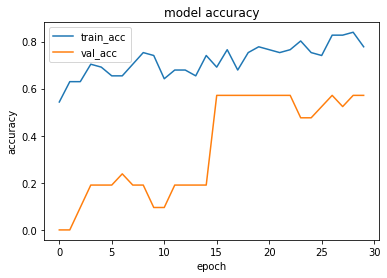

On the 3th model
Epoch 1/30
3/3 [==============================] - 1s 425ms/step - loss: 0.6608 - accuracy: 0.5556 - val_loss: 0.8623 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 448ms/step - loss: 0.6740 - accuracy: 0.6296 - val_loss: 0.9552 - val_accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 2s 733ms/step - loss: 0.6311 - accuracy: 0.6420 - val_loss: 0.9260 - val_accuracy: 0.0000e+00
Epoch 4/30
3/3 [==============================] - 1s 418ms/step - loss: 0.6012 - accuracy: 0.6914 - val_loss: 0.9010 - val_accuracy: 0.1429
Epoch 5/30
3/3 [==============================] - 1s 407ms/step - loss: 0.5794 - accuracy: 0.6914 - val_loss: 1.0638 - val_accuracy: 0.1905
Epoch 6/30
3/3 [==============================] - 1s 417ms/step - loss: 0.5980 - accuracy: 0.6790 - val_loss: 1.0540 - val_accuracy: 0.1905
Epoch 7/30
3/3 [==============================] - 1s 432ms/step - loss: 0.5847 - accuracy: 0.6790 - val_loss: 0.8951 - val_accuracy

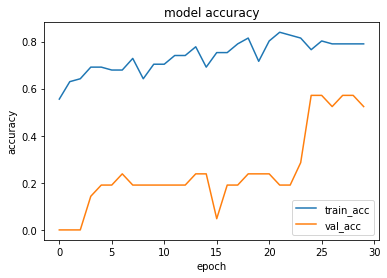

In [19]:
import tensorflow as tf 
for tf_random_seed in [0, 1, 13, 42, 69, 100]: 
    tf.random.set_seed(tf_random_seed)
    print(f"using seed {tf_random_seed}")

    base_model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64, return_sequences = True), 
        tf.keras.layers.LSTM(128, return_sequences=False), 
        tf.keras.layers.Dense(128, activation="relu"), 
        tf.keras.layers.Dense(1, activation = "sigmoid")
    ])

    dropout_model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64, return_sequences = True), 
        tf.keras.layers.Dropout(0.3), 
        tf.keras.layers.LSTM(128, return_sequences = False),  
        tf.keras.layers.Dropout(0.2), 
        tf.keras.layers.Dense(1, activation = "sigmoid")    
    ])

    aug_model = tf.keras.models.Sequential([
        Augmenter(), 
        tf.keras.layers.LSTM(64, return_sequences = True), 
        tf.keras.layers.Dropout(0.2), 
        tf.keras.layers.LSTM(128, return_sequences = False),  
        tf.keras.layers.Dropout(0.2), 
        tf.keras.layers.Dense(1, activation = "sigmoid")
    ])

    pure_aug_model = tf.keras.models.Sequential([
        Augmenter(), 
        tf.keras.layers.LSTM(64, return_sequences = True), 
        tf.keras.layers.LSTM(128, return_sequences = False),  
        tf.keras.layers.Dense(1, activation = "sigmoid")
    ])

    for i, model in enumerate([base_model, dropout_model, aug_model, pure_aug_model]): 
        print(f"On the {i}th model")
        model.compile(loss = "binary_crossentropy", optimizer = "Adam", metrics = ['accuracy']) 
    
        history = model.fit(X, y, validation_split = 0.2, epochs = 30)

        num = None if i == 0 else i 
        plot(history, num = num) 

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(
Epoch 1/30
3/3 [==============================] - 1s 424ms/step - loss: 0.4624 - accuracy: 0.7778 - val_loss: 0.5056 - val_accuracy: 0.8095
Epoch 2/30
3/3 [==============================] - 1s 404ms/step - loss: 0.4316 - accuracy: 0.8272 - val_loss: 0.5686 - val_accuracy: 0.7619
Epoch 3/30
3/3 [==============================] - 1s 412ms/step - loss: 0.4374 - accuracy: 0.7901 - val_loss: 0.6709 - val_accuracy: 0.7143
Epoch 4/30
3/3 [==============================] - 1s 397ms/step - loss: 0.4317 - accuracy: 0.7901 - val_loss: 0.7533 - val_accuracy: 0.7143
Epoch 5/30
3/3 [==============================] - 1s 39

KeyboardInterrupt: 

using random state 0
Epoch 1/30
3/3 [==============================] - 2s 499ms/step - loss: 0.7224 - accuracy: 0.4938 - val_loss: 0.6746 - val_accuracy: 0.4762
Epoch 2/30
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/backend.py", line 4518, in <genexpr>
    ta.write(time, out) for ta, out in zip(output_ta_t, flat_output))  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 247, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),
3/3 [==============================] - 1s 316ms/step - loss: 0.6793 - accuracy: 0.6420 - val_loss: 0.6749 - val_accuracy: 0.5714
Epoch 3/30
3/3 [=========================

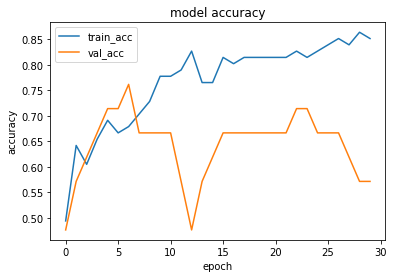

using random state 10
Epoch 1/30
3/3 [==============================] - 1s 453ms/step - loss: 0.6892 - accuracy: 0.5556 - val_loss: 0.7058 - val_accuracy: 0.5714
Epoch 2/30
3/3 [==============================] - 1s 293ms/step - loss: 0.6638 - accuracy: 0.6420 - val_loss: 0.7157 - val_accuracy: 0.5238
Epoch 3/30
3/3 [==============================] - 1s 317ms/step - loss: 0.6220 - accuracy: 0.6790 - val_loss: 0.6837 - val_accuracy: 0.5238
Epoch 4/30
3/3 [==============================] - 1s 299ms/step - loss: 0.6139 - accuracy: 0.6296 - val_loss: 0.6488 - val_accuracy: 0.5238
Epoch 5/30
3/3 [==============================] - 1s 311ms/step - loss: 0.5888 - accuracy: 0.6667 - val_loss: 0.7034 - val_accuracy: 0.6190
Epoch 6/30
3/3 [==============================] - 1s 432ms/step - loss: 0.5677 - accuracy: 0.7160 - val_loss: 0.7648 - val_accuracy: 0.5714
Epoch 7/30
3/3 [==============================] - 1s 306ms/step - loss: 0.5673 - accuracy: 0.7160 - val_loss: 0.6984 - val_accuracy: 0.666

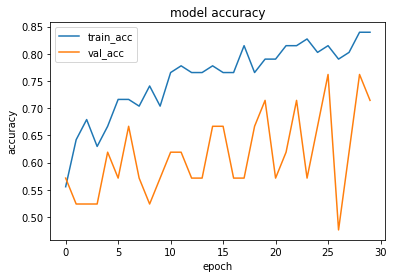

using random state 20
Epoch 1/30
3/3 [==============================] - 1s 450ms/step - loss: 0.7078 - accuracy: 0.4321 - val_loss: 0.7170 - val_accuracy: 0.3810
Epoch 2/30
3/3 [==============================] - 1s 301ms/step - loss: 0.6784 - accuracy: 0.5062 - val_loss: 0.6617 - val_accuracy: 0.7619
Epoch 3/30
3/3 [==============================] - 1s 296ms/step - loss: 0.6728 - accuracy: 0.6543 - val_loss: 0.6314 - val_accuracy: 0.8095
Epoch 4/30
3/3 [==============================] - 1s 311ms/step - loss: 0.6549 - accuracy: 0.6790 - val_loss: 0.6238 - val_accuracy: 0.7619
Epoch 5/30
3/3 [==============================] - 1s 307ms/step - loss: 0.6302 - accuracy: 0.6790 - val_loss: 0.5854 - val_accuracy: 0.7619
Epoch 6/30
3/3 [==============================] - 1s 315ms/step - loss: 0.6270 - accuracy: 0.6790 - val_loss: 0.5231 - val_accuracy: 0.7619
Epoch 7/30
3/3 [==============================] - 1s 310ms/step - loss: 0.6237 - accuracy: 0.6667 - val_loss: 0.5176 - val_accuracy: 0.761

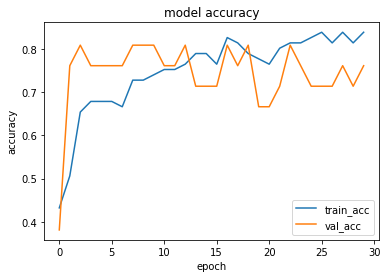

using random state 30
Epoch 1/30
3/3 [==============================] - 2s 448ms/step - loss: 0.6894 - accuracy: 0.5556 - val_loss: 0.7073 - val_accuracy: 0.3333
Epoch 2/30
3/3 [==============================] - 1s 302ms/step - loss: 0.6559 - accuracy: 0.5679 - val_loss: 0.6996 - val_accuracy: 0.5238
Epoch 3/30
3/3 [==============================] - 1s 292ms/step - loss: 0.6164 - accuracy: 0.5802 - val_loss: 0.6792 - val_accuracy: 0.6190
Epoch 4/30
3/3 [==============================] - 1s 297ms/step - loss: 0.6104 - accuracy: 0.6420 - val_loss: 0.6993 - val_accuracy: 0.5714
Epoch 5/30
3/3 [==============================] - 1s 300ms/step - loss: 0.6033 - accuracy: 0.7037 - val_loss: 0.5695 - val_accuracy: 0.6667
Epoch 6/30
3/3 [==============================] - 1s 302ms/step - loss: 0.5821 - accuracy: 0.7160 - val_loss: 0.6388 - val_accuracy: 0.6667
Epoch 7/30
3/3 [==============================] - 1s 350ms/step - loss: 0.5667 - accuracy: 0.7037 - val_loss: 0.7849 - val_accuracy: 0.571

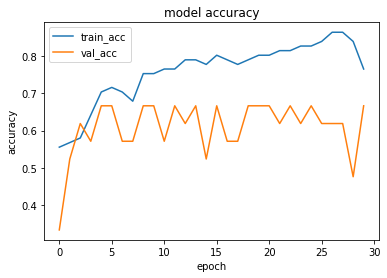

using random state 40
Epoch 1/30
3/3 [==============================] - 2s 472ms/step - loss: 0.6883 - accuracy: 0.5679 - val_loss: 0.6701 - val_accuracy: 0.6190
Epoch 2/30
3/3 [==============================] - 1s 338ms/step - loss: 0.6601 - accuracy: 0.6790 - val_loss: 0.6408 - val_accuracy: 0.6667
Epoch 3/30
3/3 [==============================] - 1s 313ms/step - loss: 0.6101 - accuracy: 0.6914 - val_loss: 0.6400 - val_accuracy: 0.6190
Epoch 4/30
3/3 [==============================] - 1s 320ms/step - loss: 0.6185 - accuracy: 0.7160 - val_loss: 0.6379 - val_accuracy: 0.5714
Epoch 5/30
3/3 [==============================] - 1s 300ms/step - loss: 0.5958 - accuracy: 0.7037 - val_loss: 0.6458 - val_accuracy: 0.6190
Epoch 6/30
3/3 [==============================] - 1s 288ms/step - loss: 0.5772 - accuracy: 0.7407 - val_loss: 0.6298 - val_accuracy: 0.6667
Epoch 7/30
3/3 [==============================] - 1s 322ms/step - loss: 0.5482 - accuracy: 0.7284 - val_loss: 0.6375 - val_accuracy: 0.666

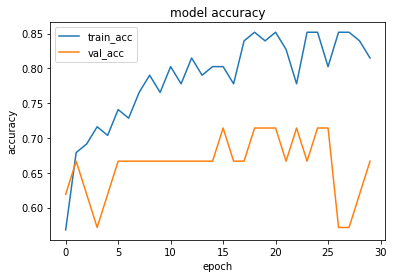

using random state 50
Epoch 1/30
3/3 [==============================] - 2s 474ms/step - loss: 0.7016 - accuracy: 0.4074 - val_loss: 0.6934 - val_accuracy: 0.5238
Epoch 2/30
3/3 [==============================] - 1s 293ms/step - loss: 0.6640 - accuracy: 0.5802 - val_loss: 0.6614 - val_accuracy: 0.7143
Epoch 3/30
3/3 [==============================] - 1s 291ms/step - loss: 0.6515 - accuracy: 0.6667 - val_loss: 0.6360 - val_accuracy: 0.6667
Epoch 4/30
3/3 [==============================] - 1s 286ms/step - loss: 0.6094 - accuracy: 0.6790 - val_loss: 0.6529 - val_accuracy: 0.7143
Epoch 5/30
3/3 [==============================] - 1s 425ms/step - loss: 0.6274 - accuracy: 0.6420 - val_loss: 0.6734 - val_accuracy: 0.6667
Epoch 6/30
3/3 [==============================] - 1s 291ms/step - loss: 0.6036 - accuracy: 0.6667 - val_loss: 0.6176 - val_accuracy: 0.6667
Epoch 7/30
3/3 [==============================] - 1s 292ms/step - loss: 0.5812 - accuracy: 0.6914 - val_loss: 0.6075 - val_accuracy: 0.714

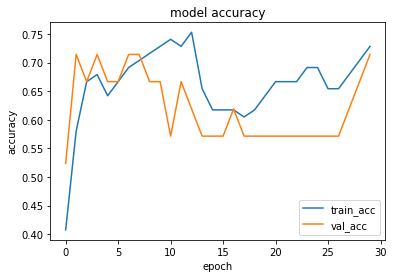

using random state 60
Epoch 1/30
3/3 [==============================] - 1s 449ms/step - loss: 0.6971 - accuracy: 0.5062 - val_loss: 0.6768 - val_accuracy: 0.4762
Epoch 2/30
3/3 [==============================] - 1s 332ms/step - loss: 0.6669 - accuracy: 0.6420 - val_loss: 0.6338 - val_accuracy: 0.7143
Epoch 3/30
3/3 [==============================] - 1s 291ms/step - loss: 0.6313 - accuracy: 0.7037 - val_loss: 0.6222 - val_accuracy: 0.6667
Epoch 4/30
3/3 [==============================] - 1s 316ms/step - loss: 0.6400 - accuracy: 0.6914 - val_loss: 0.6114 - val_accuracy: 0.6667
Epoch 5/30
3/3 [==============================] - 1s 342ms/step - loss: 0.6168 - accuracy: 0.6667 - val_loss: 0.6046 - val_accuracy: 0.7619
Epoch 6/30
3/3 [==============================] - 1s 302ms/step - loss: 0.5983 - accuracy: 0.6790 - val_loss: 0.6239 - val_accuracy: 0.7619
Epoch 7/30
3/3 [==============================] - 1s 288ms/step - loss: 0.5881 - accuracy: 0.6790 - val_loss: 0.6557 - val_accuracy: 0.761

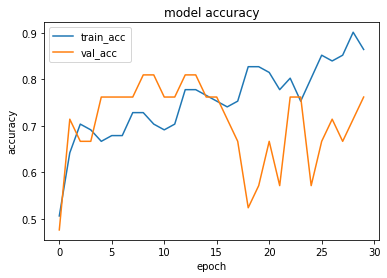

using random state 70
Epoch 1/30
3/3 [==============================] - 1s 461ms/step - loss: 0.6998 - accuracy: 0.4198 - val_loss: 0.6760 - val_accuracy: 0.5238
Epoch 2/30
3/3 [==============================] - 1s 293ms/step - loss: 0.6595 - accuracy: 0.5679 - val_loss: 0.6707 - val_accuracy: 0.4286
Epoch 3/30
3/3 [==============================] - 1s 290ms/step - loss: 0.6327 - accuracy: 0.6049 - val_loss: 0.6168 - val_accuracy: 0.5714
Epoch 4/30
3/3 [==============================] - 1s 318ms/step - loss: 0.6341 - accuracy: 0.5802 - val_loss: 0.6187 - val_accuracy: 0.5238
Epoch 5/30
3/3 [==============================] - 1s 294ms/step - loss: 0.6122 - accuracy: 0.6173 - val_loss: 0.6101 - val_accuracy: 0.5238
Epoch 6/30
3/3 [==============================] - 1s 292ms/step - loss: 0.5910 - accuracy: 0.6420 - val_loss: 0.6176 - val_accuracy: 0.5238
Epoch 7/30
3/3 [==============================] - 1s 294ms/step - loss: 0.5766 - accuracy: 0.7037 - val_loss: 0.6194 - val_accuracy: 0.523

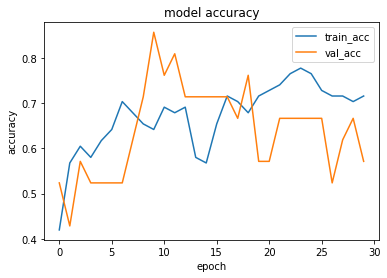

using random state 80
Epoch 1/30
3/3 [==============================] - 2s 516ms/step - loss: 0.6882 - accuracy: 0.4691 - val_loss: 0.6764 - val_accuracy: 0.5238
Epoch 2/30
3/3 [==============================] - 1s 310ms/step - loss: 0.6599 - accuracy: 0.5802 - val_loss: 0.6319 - val_accuracy: 0.5714
Epoch 3/30
3/3 [==============================] - 1s 330ms/step - loss: 0.6480 - accuracy: 0.5926 - val_loss: 0.5960 - val_accuracy: 0.5714
Epoch 4/30
3/3 [==============================] - 1s 305ms/step - loss: 0.6286 - accuracy: 0.6049 - val_loss: 0.6077 - val_accuracy: 0.5714
Epoch 5/30
3/3 [==============================] - 1s 299ms/step - loss: 0.6220 - accuracy: 0.6049 - val_loss: 0.5954 - val_accuracy: 0.5714
Epoch 6/30
3/3 [==============================] - 1s 315ms/step - loss: 0.6230 - accuracy: 0.6049 - val_loss: 0.6061 - val_accuracy: 0.6667
Epoch 7/30
3/3 [==============================] - 1s 323ms/step - loss: 0.6134 - accuracy: 0.6420 - val_loss: 0.5828 - val_accuracy: 0.809

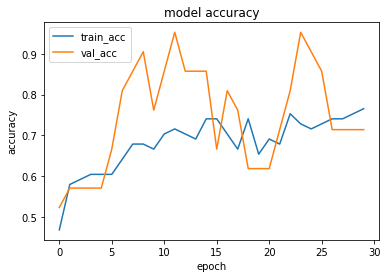

using random state 90
Epoch 1/30
3/3 [==============================] - 1s 462ms/step - loss: 0.7019 - accuracy: 0.4321 - val_loss: 0.6917 - val_accuracy: 0.6667
Epoch 2/30
3/3 [==============================] - 1s 323ms/step - loss: 0.6560 - accuracy: 0.6543 - val_loss: 0.7336 - val_accuracy: 0.3333
Epoch 3/30
3/3 [==============================] - 1s 346ms/step - loss: 0.6391 - accuracy: 0.6173 - val_loss: 0.7543 - val_accuracy: 0.3810
Epoch 4/30
3/3 [==============================] - 1s 305ms/step - loss: 0.5924 - accuracy: 0.6296 - val_loss: 0.7204 - val_accuracy: 0.4286
Epoch 5/30
3/3 [==============================] - 1s 314ms/step - loss: 0.5905 - accuracy: 0.6543 - val_loss: 0.7798 - val_accuracy: 0.5238
Epoch 6/30
3/3 [==============================] - 1s 328ms/step - loss: 0.5889 - accuracy: 0.6914 - val_loss: 0.7759 - val_accuracy: 0.6667
Epoch 7/30
3/3 [==============================] - 1s 293ms/step - loss: 0.5757 - accuracy: 0.7160 - val_loss: 0.7634 - val_accuracy: 0.619

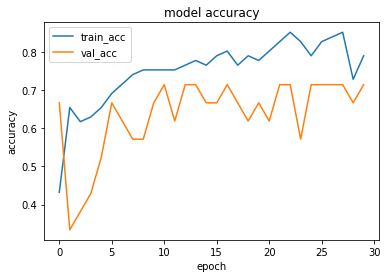

In [12]:
from sklearn.model_selection import train_test_split
for random_state in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]: 
    print(f"using random state {random_state}")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=random_state)
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64, return_sequences = True), 
        tf.keras.layers.LSTM(128, return_sequences=False), 
        tf.keras.layers.Dense(1, activation = "sigmoid")
    ])
    model.compile(loss = "binary_crossentropy", optimizer = "Adam", metrics = ['accuracy'])

    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 30)

    plot(history)

using random state 0
Epoch 1/30
3/3 [==============================] - 2s 495ms/step - loss: 0.6845 - accuracy: 0.4938 - val_loss: 0.6619 - val_accuracy: 0.5714
Epoch 2/30
3/3 [==============================] - 1s 308ms/step - loss: 0.6664 - accuracy: 0.5556 - val_loss: 0.6062 - val_accuracy: 0.7143
Epoch 3/30
3/3 [==============================] - 1s 304ms/step - loss: 0.6314 - accuracy: 0.5679 - val_loss: 0.5608 - val_accuracy: 0.9524
Epoch 4/30
3/3 [==============================] - 1s 289ms/step - loss: 0.6351 - accuracy: 0.6173 - val_loss: 0.5498 - val_accuracy: 0.8095
Epoch 5/30
3/3 [==============================] - 1s 303ms/step - loss: 0.6174 - accuracy: 0.6790 - val_loss: 0.5878 - val_accuracy: 0.7619
Epoch 6/30
3/3 [==============================] - 1s 298ms/step - loss: 0.6094 - accuracy: 0.7160 - val_loss: 0.5908 - val_accuracy: 0.7619
Epoch 7/30
3/3 [==============================] - 1s 295ms/step - loss: 0.5963 - accuracy: 0.7407 - val_loss: 0.5437 - val_accuracy: 0.7619

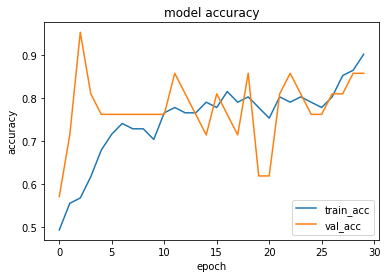

using random state 10
Epoch 1/30
3/3 [==============================] - 2s 562ms/step - loss: 0.6954 - accuracy: 0.4938 - val_loss: 0.6683 - val_accuracy: 0.7619
Epoch 2/30
3/3 [==============================] - 1s 291ms/step - loss: 0.6657 - accuracy: 0.7160 - val_loss: 0.6573 - val_accuracy: 0.7143
Epoch 3/30
3/3 [==============================] - 1s 296ms/step - loss: 0.6456 - accuracy: 0.6914 - val_loss: 0.5880 - val_accuracy: 0.8095
Epoch 4/30
3/3 [==============================] - 1s 290ms/step - loss: 0.6300 - accuracy: 0.6790 - val_loss: 0.5528 - val_accuracy: 0.7619
Epoch 5/30
3/3 [==============================] - 1s 296ms/step - loss: 0.6147 - accuracy: 0.6914 - val_loss: 0.5814 - val_accuracy: 0.7619
Epoch 6/30
3/3 [==============================] - 1s 285ms/step - loss: 0.6026 - accuracy: 0.7160 - val_loss: 0.5605 - val_accuracy: 0.7619
Epoch 7/30
3/3 [==============================] - 1s 291ms/step - loss: 0.6053 - accuracy: 0.7160 - val_loss: 0.5932 - val_accuracy: 0.714

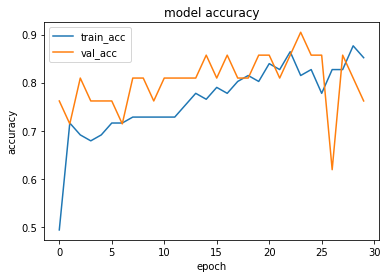

using random state 20
Epoch 1/30
3/3 [==============================] - 1s 418ms/step - loss: 0.6916 - accuracy: 0.5432 - val_loss: 0.6679 - val_accuracy: 0.7143
Epoch 2/30
3/3 [==============================] - 1s 282ms/step - loss: 0.6642 - accuracy: 0.6173 - val_loss: 0.6512 - val_accuracy: 0.7143
Epoch 3/30
3/3 [==============================] - 1s 276ms/step - loss: 0.6445 - accuracy: 0.6790 - val_loss: 0.5594 - val_accuracy: 0.7619
Epoch 4/30
3/3 [==============================] - 1s 279ms/step - loss: 0.6372 - accuracy: 0.6543 - val_loss: 0.5430 - val_accuracy: 0.7619
Epoch 5/30
3/3 [==============================] - 1s 276ms/step - loss: 0.6208 - accuracy: 0.6914 - val_loss: 0.5712 - val_accuracy: 0.7619
Epoch 6/30
3/3 [==============================] - 1s 278ms/step - loss: 0.6028 - accuracy: 0.7284 - val_loss: 0.5624 - val_accuracy: 0.7619
Epoch 7/30
3/3 [==============================] - 1s 300ms/step - loss: 0.6033 - accuracy: 0.7037 - val_loss: 0.5624 - val_accuracy: 0.809

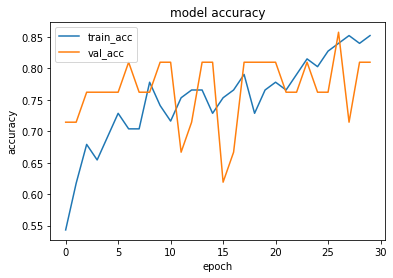

using random state 30
Epoch 1/30
3/3 [==============================] - 1s 453ms/step - loss: 0.6994 - accuracy: 0.4691 - val_loss: 0.6668 - val_accuracy: 0.6190
Epoch 2/30
3/3 [==============================] - 1s 284ms/step - loss: 0.6677 - accuracy: 0.5802 - val_loss: 0.6643 - val_accuracy: 0.7143
Epoch 3/30
3/3 [==============================] - 1s 294ms/step - loss: 0.6523 - accuracy: 0.6790 - val_loss: 0.6013 - val_accuracy: 0.7619
Epoch 4/30
3/3 [==============================] - 1s 305ms/step - loss: 0.6324 - accuracy: 0.6667 - val_loss: 0.5450 - val_accuracy: 0.8571
Epoch 5/30
3/3 [==============================] - 1s 304ms/step - loss: 0.6245 - accuracy: 0.6667 - val_loss: 0.5261 - val_accuracy: 0.7619
Epoch 6/30
3/3 [==============================] - 1s 417ms/step - loss: 0.6114 - accuracy: 0.6914 - val_loss: 0.5365 - val_accuracy: 0.7619
Epoch 7/30
3/3 [==============================] - 1s 278ms/step - loss: 0.5968 - accuracy: 0.7160 - val_loss: 0.5436 - val_accuracy: 0.761

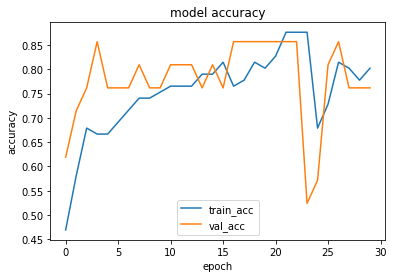

using random state 40
Epoch 1/30
3/3 [==============================] - 1s 457ms/step - loss: 0.6853 - accuracy: 0.5556 - val_loss: 0.6570 - val_accuracy: 0.9048
Epoch 2/30
3/3 [==============================] - 1s 302ms/step - loss: 0.6550 - accuracy: 0.6173 - val_loss: 0.5966 - val_accuracy: 0.8571
Epoch 3/30
3/3 [==============================] - 1s 335ms/step - loss: 0.6287 - accuracy: 0.6790 - val_loss: 0.5619 - val_accuracy: 0.8095
Epoch 4/30
3/3 [==============================] - 1s 305ms/step - loss: 0.6230 - accuracy: 0.6790 - val_loss: 0.5228 - val_accuracy: 0.8095
Epoch 5/30
3/3 [==============================] - 1s 299ms/step - loss: 0.6082 - accuracy: 0.6914 - val_loss: 0.5616 - val_accuracy: 0.7619
Epoch 6/30
3/3 [==============================] - 1s 301ms/step - loss: 0.5906 - accuracy: 0.7160 - val_loss: 0.5700 - val_accuracy: 0.7619
Epoch 7/30
3/3 [==============================] - 1s 320ms/step - loss: 0.5796 - accuracy: 0.7284 - val_loss: 0.5687 - val_accuracy: 0.761

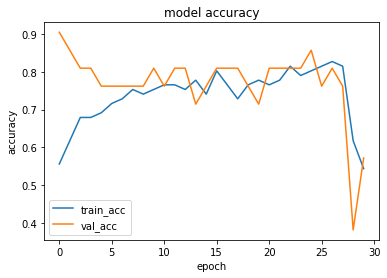

using random state 50
Epoch 1/30
3/3 [==============================] - 2s 441ms/step - loss: 0.7022 - accuracy: 0.4815 - val_loss: 0.6809 - val_accuracy: 0.5714
Epoch 2/30
3/3 [==============================] - 1s 287ms/step - loss: 0.6810 - accuracy: 0.5556 - val_loss: 0.6283 - val_accuracy: 0.6667
Epoch 3/30
3/3 [==============================] - 1s 287ms/step - loss: 0.6584 - accuracy: 0.5802 - val_loss: 0.5984 - val_accuracy: 0.9048
Epoch 4/30
3/3 [==============================] - 1s 294ms/step - loss: 0.6340 - accuracy: 0.6543 - val_loss: 0.5690 - val_accuracy: 0.7619
Epoch 5/30
3/3 [==============================] - 1s 306ms/step - loss: 0.6232 - accuracy: 0.6790 - val_loss: 0.5403 - val_accuracy: 0.8095
Epoch 6/30
3/3 [==============================] - 1s 283ms/step - loss: 0.6186 - accuracy: 0.6790 - val_loss: 0.5474 - val_accuracy: 0.7619
Epoch 7/30
3/3 [==============================] - 1s 277ms/step - loss: 0.6046 - accuracy: 0.7160 - val_loss: 0.5623 - val_accuracy: 0.761

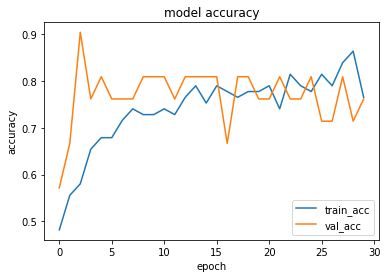

using random state 60
Epoch 1/30
3/3 [==============================] - 1s 438ms/step - loss: 0.6961 - accuracy: 0.5185 - val_loss: 0.6741 - val_accuracy: 0.7143
Epoch 2/30
3/3 [==============================] - 1s 290ms/step - loss: 0.6742 - accuracy: 0.5679 - val_loss: 0.6657 - val_accuracy: 0.6667
Epoch 3/30
3/3 [==============================] - 1s 284ms/step - loss: 0.6473 - accuracy: 0.5556 - val_loss: 0.5822 - val_accuracy: 0.8571
Epoch 4/30
3/3 [==============================] - 1s 286ms/step - loss: 0.6419 - accuracy: 0.6173 - val_loss: 0.5299 - val_accuracy: 0.9048
Epoch 5/30
3/3 [==============================] - 1s 275ms/step - loss: 0.6132 - accuracy: 0.6667 - val_loss: 0.5647 - val_accuracy: 0.7619
Epoch 6/30
3/3 [==============================] - 1s 290ms/step - loss: 0.6267 - accuracy: 0.7284 - val_loss: 0.6260 - val_accuracy: 0.7143
Epoch 7/30
3/3 [==============================] - 1s 278ms/step - loss: 0.6112 - accuracy: 0.7284 - val_loss: 0.5563 - val_accuracy: 0.761

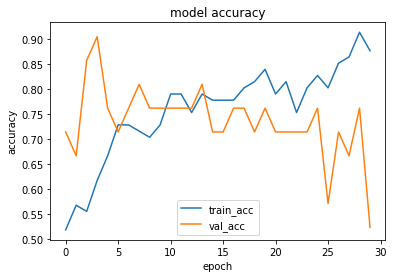

using random state 70
Epoch 1/30
3/3 [==============================] - 1s 454ms/step - loss: 0.6954 - accuracy: 0.4691 - val_loss: 0.6811 - val_accuracy: 0.6190
Epoch 2/30
3/3 [==============================] - 1s 391ms/step - loss: 0.6684 - accuracy: 0.6296 - val_loss: 0.6322 - val_accuracy: 0.7143
Epoch 3/30
3/3 [==============================] - 1s 294ms/step - loss: 0.6480 - accuracy: 0.6420 - val_loss: 0.5422 - val_accuracy: 0.9524
Epoch 4/30
3/3 [==============================] - 1s 303ms/step - loss: 0.6338 - accuracy: 0.6173 - val_loss: 0.5194 - val_accuracy: 0.9524
Epoch 5/30
3/3 [==============================] - 1s 290ms/step - loss: 0.6146 - accuracy: 0.6543 - val_loss: 0.5759 - val_accuracy: 0.8095
Epoch 6/30
3/3 [==============================] - 1s 292ms/step - loss: 0.6172 - accuracy: 0.6914 - val_loss: 0.5713 - val_accuracy: 0.7619
Epoch 7/30
3/3 [==============================] - 1s 282ms/step - loss: 0.6014 - accuracy: 0.7037 - val_loss: 0.5604 - val_accuracy: 0.761

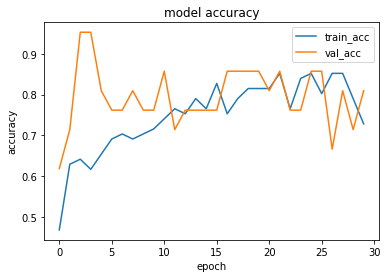

using random state 80
Epoch 1/30
3/3 [==============================] - 2s 479ms/step - loss: 0.7044 - accuracy: 0.5062 - val_loss: 0.6883 - val_accuracy: 0.4286
Epoch 2/30
3/3 [==============================] - 1s 316ms/step - loss: 0.6683 - accuracy: 0.5679 - val_loss: 0.6433 - val_accuracy: 0.6667
Epoch 3/30
3/3 [==============================] - 1s 312ms/step - loss: 0.6566 - accuracy: 0.5556 - val_loss: 0.5848 - val_accuracy: 0.6667
Epoch 4/30
3/3 [==============================] - 1s 341ms/step - loss: 0.6422 - accuracy: 0.5802 - val_loss: 0.5740 - val_accuracy: 0.8095
Epoch 5/30
3/3 [==============================] - 1s 418ms/step - loss: 0.6188 - accuracy: 0.6049 - val_loss: 0.5627 - val_accuracy: 0.9048
Epoch 6/30
3/3 [==============================] - 1s 313ms/step - loss: 0.6077 - accuracy: 0.6543 - val_loss: 0.5589 - val_accuracy: 0.8095
Epoch 7/30
3/3 [==============================] - 1s 316ms/step - loss: 0.5968 - accuracy: 0.6914 - val_loss: 0.5602 - val_accuracy: 0.761

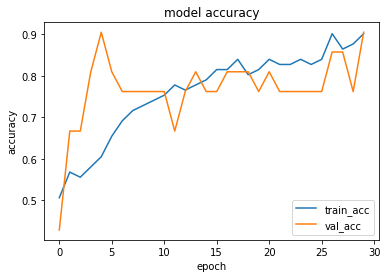

using random state 90
Epoch 1/30
3/3 [==============================] - 2s 491ms/step - loss: 0.6900 - accuracy: 0.5185 - val_loss: 0.6937 - val_accuracy: 0.3333
Epoch 2/30
3/3 [==============================] - 1s 315ms/step - loss: 0.6800 - accuracy: 0.4568 - val_loss: 0.6602 - val_accuracy: 0.7619
Epoch 3/30
3/3 [==============================] - 1s 315ms/step - loss: 0.6510 - accuracy: 0.6296 - val_loss: 0.5788 - val_accuracy: 0.9048
Epoch 4/30
3/3 [==============================] - 1s 314ms/step - loss: 0.6306 - accuracy: 0.6420 - val_loss: 0.5560 - val_accuracy: 0.9048
Epoch 5/30
3/3 [==============================] - 1s 334ms/step - loss: 0.6308 - accuracy: 0.6173 - val_loss: 0.5200 - val_accuracy: 0.8571
Epoch 6/30
3/3 [==============================] - 1s 317ms/step - loss: 0.6279 - accuracy: 0.6790 - val_loss: 0.6060 - val_accuracy: 0.7143
Epoch 7/30
3/3 [==============================] - 1s 311ms/step - loss: 0.6134 - accuracy: 0.7160 - val_loss: 0.5811 - val_accuracy: 0.761

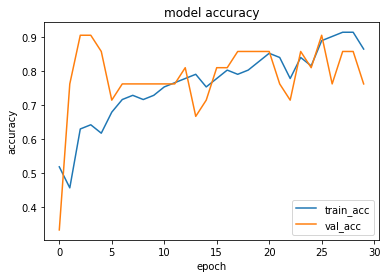

In [15]:
from sklearn.model_selection import train_test_split
N = np.random.permutation(X.shape[0])
X = X[N]
y = y[N]
for random_state in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]: 
    print(f"using random state {random_state}")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=random_state)
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64, return_sequences = True), 
        tf.keras.layers.LSTM(128, return_sequences=False), 
        tf.keras.layers.Dense(1, activation = "sigmoid")
    ])
    model.compile(loss = "binary_crossentropy", optimizer = "Adam", metrics = ['accuracy'])

    history = model.fit(X, y, validation_split=0.2, epochs = 30)

    plot(history)

# We'll continue trying to find the best model until we find it, and then we can move on to 1 point and then 6 points usage. 

Epoch 1/30
3/3 [==============================] - 1s 344ms/step - loss: 0.7237 - accuracy: 0.4691 - val_loss: 0.7027 - val_accuracy: 0.4286
Epoch 2/30
3/3 [==============================] - 1s 367ms/step - loss: 0.7011 - accuracy: 0.5432 - val_loss: 0.6734 - val_accuracy: 0.5238
Epoch 3/30
3/3 [==============================] - 1s 309ms/step - loss: 0.6910 - accuracy: 0.5432 - val_loss: 0.6485 - val_accuracy: 0.5238
Epoch 4/30
3/3 [==============================] - 1s 312ms/step - loss: 0.6716 - accuracy: 0.5802 - val_loss: 0.6361 - val_accuracy: 0.5238
Epoch 5/30
3/3 [==============================] - 1s 298ms/step - loss: 0.6713 - accuracy: 0.5802 - val_loss: 0.6209 - val_accuracy: 0.5238
Epoch 6/30
3/3 [==============================] - 1s 298ms/step - loss: 0.6620 - accuracy: 0.5802 - val_loss: 0.6090 - val_accuracy: 0.5238
Epoch 7/30
3/3 [==============================] - 1s 309ms/step - loss: 0.6434 - accuracy: 0.5802 - val_loss: 0.5906 - val_accuracy: 0.5238
Epoch 8/30
3/3 [====

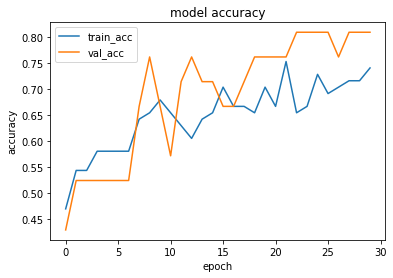

3/3 [==============================] - 0s 56ms/step - loss: 0.5015 - accuracy: 0.7778
evaluation on training data w/o augs:  [0.5014669895172119, 0.7777777910232544]
1/1 [==============================] - 0s 68ms/step - loss: 0.5279 - accuracy: 0.8095
evaluation on testing data:  [0.5279345512390137, 0.8095238208770752]


In [37]:
model = tf.keras.models.Sequential([
    Augmenter(), 
    tf.keras.layers.LSTM(128, return_sequences = False),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

model.compile(loss = "binary_crossentropy", optimizer = "Adam", metrics = ['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 30)

plot(history)

print("evaluation on training data w/o augs: ", model.evaluate(X_train, y_train))
print('evaluation on testing data: ', model.evaluate(X_test, y_test))

In [12]:
import pickle
import os
import numpy as np 

X = []
y = []

for file in os.listdir('all_points_folds'): 
    with open(f"all_points_folds/{file}", 'rb') as f: 
        X_i, y_i = pickle.load(f)
        X.append(X_i)
        y.append(y_i)

X = np.array(X)
y = np.array(y)

In [13]:
from glob import glob
def cross_validate(model, epochs = 50, callbacks=[]):
    for i in range(X.shape[0]): 
        X_test, y_test = X[i], y[i]
        X_train = np.concatenate([X_j for j, X_j in enumerate(X) if i != j])
        y_train = np.concatenate([y_j for j, y_j in enumerate(y) if i != j])

        M = np.random.permutation(X_train.shape[0])
        X_train, y_train = X_train[M], y_train[M]
        # train 
        history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, callbacks = callbacks)

        # plot accuracy and loss 
        plot(history)

        # evaluate on our own custom videos
        for file in glob("*.mov"):
            print(f"file is {file}, prediction is {predict_on_video(model, file)}")

In [71]:
def generate_new_fold(num = 4):
    X_train = np.concatenate([X_j for j, X_j in enumerate(X) if j != num])
    y_train = np.concatenate([y_j for j, y_j in enumerate(y) if j != num]) # don't use the last one 
    X_test, y_test = X[num], y[num]

In [72]:
generate_new_fold(num=3)

In [58]:
def ensemble_val_acc(models, X_test, y_test): 
    y_pred = np.zeros_like(y_test)
    for model in models: 
        y_pred += model.predict(X_test).flatten()
    y_pred = y_pred / len(models)
    y_pred = np.round_(y_pred)
    return (y_pred == y_test).sum() / y_pred.shape[0]

Epoch 1/50
3/3 [==============================] - 1s 230ms/step - loss: 0.6971 - accuracy: 0.5500 - val_loss: 0.6694 - val_accuracy: 0.6000
Epoch 2/50
3/3 [==============================] - 0s 138ms/step - loss: 0.6937 - accuracy: 0.5000 - val_loss: 0.6628 - val_accuracy: 0.7000
Epoch 3/50
3/3 [==============================] - 0s 141ms/step - loss: 0.6785 - accuracy: 0.5625 - val_loss: 0.6515 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 0s 158ms/step - loss: 0.6682 - accuracy: 0.6375 - val_loss: 0.6400 - val_accuracy: 0.7500
Epoch 5/50
3/3 [==============================] - 0s 154ms/step - loss: 0.6670 - accuracy: 0.7000 - val_loss: 0.6324 - val_accuracy: 0.8000
Epoch 6/50
3/3 [==============================] - 0s 140ms/step - loss: 0.6634 - accuracy: 0.7125 - val_loss: 0.6250 - val_accuracy: 0.8000
Epoch 7/50
3/3 [==============================] - 0s 136ms/step - loss: 0.6577 - accuracy: 0.7125 - val_loss: 0.6168 - val_accuracy: 0.8000
Epoch 8/50
3/3 [====

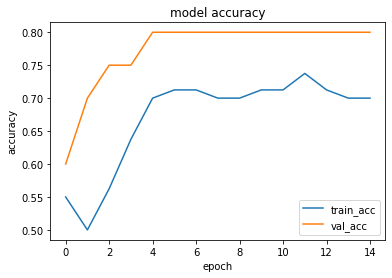

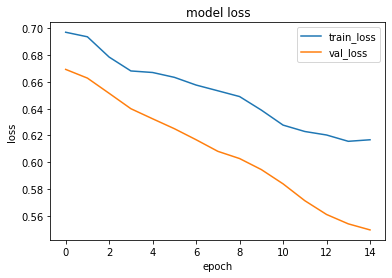

1it [00:00, 18157.16it/s]
file is another_control.mov, prediction is [[0.1881448]]
1it [00:00, 17476.27it/s]
file is short_armflapping.mov, prediction is [[0.54740334]]
1it [00:00, 17476.27it/s]
file is control_far.mov, prediction is [[0.73459274]]
1it [00:00, 18893.26it/s]
file is long_armflapping.mov, prediction is [[0.6842872]]
1it [00:00, 18558.87it/s]
file is me_reading_control.mov, prediction is [[0.30626166]]
1it [00:00, 14315.03it/s]file is me_armflapping.mov, prediction is [[0.3329628]]



In [74]:
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False), 
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(1, activation="sigmoid")
])

es = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
 
model_1.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])
history = model_1.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50, callbacks = [])

# plot accuracy and loss 
plot(history)

# evaluate on our own custom videos
for file in glob("*.mov"):
    print(f"file is {file}, prediction is {predict_on_video(model_1, file)}")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(
Epoch 1/30
3/3 [==============================] - 1s 238ms/step - loss: 0.6851 - accuracy: 0.5000 - val_loss: 0.6981 - val_accuracy: 0.3500
Epoch 2/30
3/3 [==============================] - 0s 153ms/step - loss: 0.6822 - accuracy: 0.5375 - val_loss: 0.6841 - val_accuracy: 0.5500
Epoch 3/30
3/3 [==============================] - 0s 150ms/step - loss: 0.6814 - accuracy: 0.5375 - val_loss: 0.6756 - val_accuracy: 0.5500
Epoch 4/30
3/3 [==============================] - 0s 146ms/step - loss: 0.6769 - accuracy: 0.6000 - val_loss: 0.6687 - val_accuracy: 0.6500
Epoch 5/30
3/3 [==============================] - 0s 15

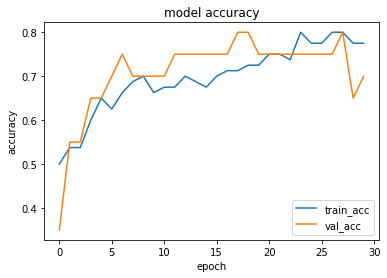

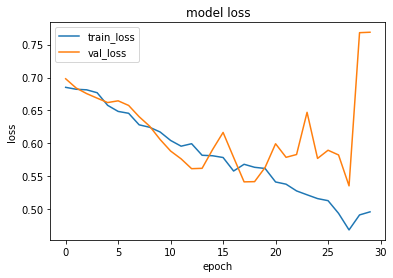

1it [00:00, 14716.86it/s]
file is another_control.mov, prediction is [[0.04463863]]
1it [00:00, 17848.10it/s]
file is short_armflapping.mov, prediction is [[0.58627707]]
1it [00:00, 17924.38it/s]
file is control_far.mov, prediction is [[0.32568574]]
1it [00:00, 18808.54it/s]
file is long_armflapping.mov, prediction is [[0.6305624]]
1it [00:00, 18893.26it/s]
file is me_reading_control.mov, prediction is [[0.5166521]]
1it [00:00, 17848.10it/s]file is me_armflapping.mov, prediction is [[0.39452183]]



In [46]:
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=False), 
    tf.keras.layers.Dropout(0.3), 
    tf.keras.layers.Dense(1, activation="sigmoid")
])

es = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
model_2.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])
history = model_2.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 30, callbacks = [])

# plot accuracy and loss 
plot(history)

# evaluate on our own custom videos
for file in glob("*.mov"):
    print(f"file is {file}, prediction is {predict_on_video(model_2, file)}")

In [59]:
ensemble_val_acc([model_1, model_2], X_test, y_test)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


0.75

Epoch 1/30
3/3 [==============================] - 1s 216ms/step - loss: 0.7094 - accuracy: 0.4875 - val_loss: 0.7046 - val_accuracy: 0.4000
Epoch 2/30
3/3 [==============================] - 0s 137ms/step - loss: 0.7093 - accuracy: 0.4250 - val_loss: 0.6943 - val_accuracy: 0.7000
Epoch 3/30
3/3 [==============================] - 0s 152ms/step - loss: 0.7027 - accuracy: 0.5750 - val_loss: 0.6852 - val_accuracy: 0.7000
Epoch 4/30
3/3 [==============================] - 0s 137ms/step - loss: 0.6899 - accuracy: 0.5625 - val_loss: 0.6772 - val_accuracy: 0.7000
Epoch 5/30
3/3 [==============================] - 0s 132ms/step - loss: 0.6878 - accuracy: 0.6375 - val_loss: 0.6698 - val_accuracy: 0.7000
Epoch 6/30
3/3 [==============================] - 0s 132ms/step - loss: 0.6904 - accuracy: 0.6250 - val_loss: 0.6620 - val_accuracy: 0.8000
Epoch 7/30
3/3 [==============================] - 0s 128ms/step - loss: 0.6760 - accuracy: 0.6375 - val_loss: 0.6558 - val_accuracy: 0.7500
Epoch 8/30
3/3 [====

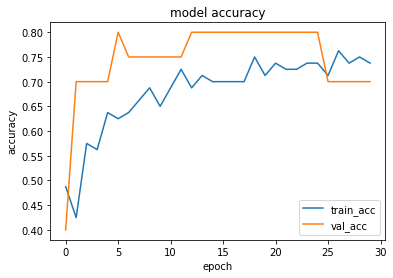

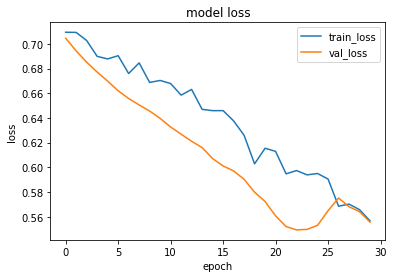

1it [00:00, 18157.16it/s]
file is another_control.mov, prediction is [[0.12355113]]
1it [00:00, 17848.10it/s]
file is short_armflapping.mov, prediction is [[0.60104626]]
1it [00:00, 18808.54it/s]
file is control_far.mov, prediction is [[0.7635436]]
1it [00:00, 19239.93it/s]
file is long_armflapping.mov, prediction is [[0.30452728]]
1it [00:00, 16912.52it/s]
file is me_reading_control.mov, prediction is [[0.1554996]]
1it [00:00, 19239.93it/s]file is me_armflapping.mov, prediction is [[0.21465766]]



In [62]:
model_3 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False), 
    tf.keras.layers.Dropout(0.3), 
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

es = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
model_3.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])
history = model_3.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 30, callbacks = [])

# plot accuracy and loss 
plot(history)

# evaluate on our own custom videos
for file in glob("*.mov"):
    print(f"file is {file}, prediction is {predict_on_video(model_3, file)}")

In [63]:
ensemble_val_acc([model_1, model_2, model_3], X_test, y_test)

0.75

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(
Epoch 1/30
3/3 [==============================] - 1s 298ms/step - loss: 0.7112 - accuracy: 0.4750 - val_loss: 0.6917 - val_accuracy: 0.4000
Epoch 2/30
3/3 [==============================] - 1s 269ms/step - loss: 0.6790 - accuracy: 0.6000 - val_loss: 0.6719 - val_accuracy: 0.6000
Epoch 3/30
3/3 [==============================] - 1s 276ms/step - loss: 0.6822 - accuracy: 0.6000 - val_loss: 0.6593 - val_accuracy: 0.6000
Epoch 4/30
3/3 [==============================] - 1s 257ms/step - loss: 0.6694 - accuracy: 0.6375 - val_loss: 0.6482 - val_accuracy: 0.6000
Epoch 5/30
3/3 [==============================] - 1s 25

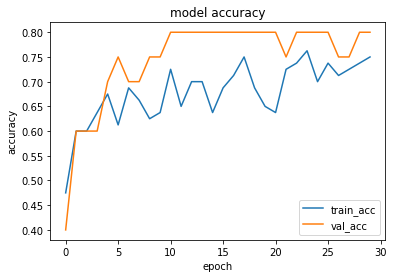

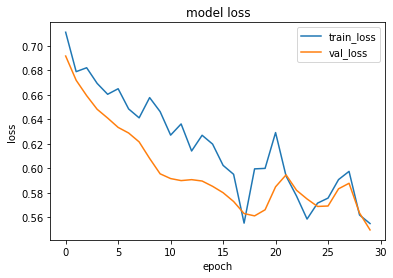

1it [00:00, 18157.16it/s]
file is another_control.mov, prediction is [[0.06358898]]
1it [00:00, 18477.11it/s]
file is short_armflapping.mov, prediction is [[0.5802224]]
1it [00:00, 16912.52it/s]
file is control_far.mov, prediction is [[0.77007896]]
1it [00:00, 18558.87it/s]
file is long_armflapping.mov, prediction is [[0.44175112]]
1it [00:00, 15827.56it/s]
file is me_reading_control.mov, prediction is [[0.2513348]]
1it [00:00, 19599.55it/s]file is me_armflapping.mov, prediction is [[0.23673302]]



In [64]:
model_4 = tf.keras.models.Sequential([
    Augmenter(), 
    tf.keras.layers.LSTM(64, return_sequences=False), 
    tf.keras.layers.Dense(1, activation="sigmoid")
])

es = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
model_4.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])
history = model_4.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 30, callbacks = [])

# plot accuracy and loss 
plot(history)

# evaluate on our own custom videos
for file in glob("*.mov"):
    print(f"file is {file}, prediction is {predict_on_video(model_4, file)}")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(
Epoch 1/30
3/3 [==============================] - 1s 264ms/step - loss: 0.6971 - accuracy: 0.5125 - val_loss: 0.7183 - val_accuracy: 0.4500
Epoch 2/30
3/3 [==============================] - 1s 268ms/step - loss: 0.7085 - accuracy: 0.4250 - val_loss: 0.7079 - val_accuracy: 0.4500
Epoch 3/30
3/3 [==============================] - 1s 272ms/step - loss: 0.7052 - accuracy: 0.4375 - val_loss: 0.6956 - val_accuracy: 0.4500
Epoch 4/30
3/3 [==============================] - 1s 482ms/step - loss: 0.6915 - accuracy: 0.5375 - val_loss: 0.6885 - val_accuracy: 0.5500
Epoch 5/30
3/3 [==============================] - 1s 28

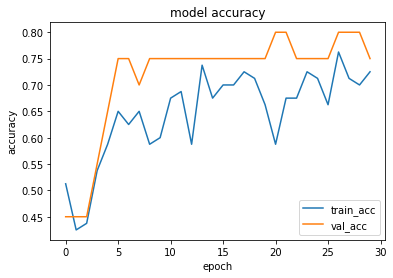

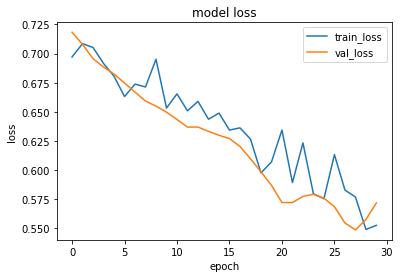

In [77]:
# train diverse classifiers
div_1 = tf.keras.models.Sequential([
    Augmenter(), 
    tf.keras.layers.LSTM(64, return_sequences = False), 
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(1, activation="sigmoid")
])

es = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
div_1.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])
history = div_1.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 30, callbacks = [])

# plot accuracy and loss 
plot(history)

Epoch 1/30
3/3 [==============================] - 1s 213ms/step - loss: 0.7216 - accuracy: 0.5000 - val_loss: 0.6918 - val_accuracy: 0.5500
Epoch 2/30
3/3 [==============================] - 1s 199ms/step - loss: 0.7018 - accuracy: 0.6125 - val_loss: 0.6696 - val_accuracy: 0.5000
Epoch 3/30
3/3 [==============================] - 1s 233ms/step - loss: 0.7015 - accuracy: 0.5500 - val_loss: 0.6594 - val_accuracy: 0.6000
Epoch 4/30
3/3 [==============================] - 1s 198ms/step - loss: 0.6571 - accuracy: 0.6375 - val_loss: 0.6531 - val_accuracy: 0.5500
Epoch 5/30
3/3 [==============================] - 1s 201ms/step - loss: 0.6773 - accuracy: 0.5000 - val_loss: 0.6474 - val_accuracy: 0.6000
Epoch 6/30
3/3 [==============================] - 1s 204ms/step - loss: 0.6733 - accuracy: 0.5625 - val_loss: 0.6449 - val_accuracy: 0.6500
Epoch 7/30
3/3 [==============================] - 1s 199ms/step - loss: 0.6685 - accuracy: 0.6000 - val_loss: 0.6375 - val_accuracy: 0.6000
Epoch 8/30
3/3 [====

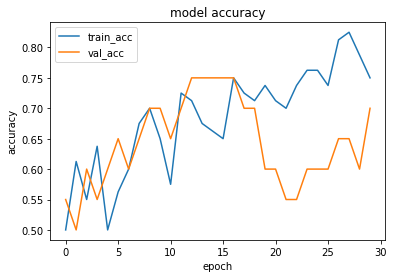

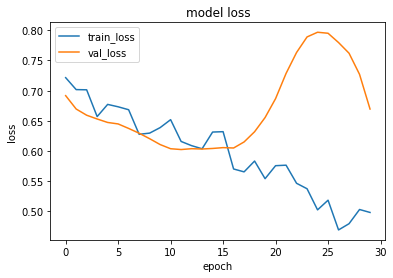

In [78]:
# train diverse classifiers
div_2 = tf.keras.models.Sequential([
    Augmenter(), 
    tf.keras.layers.SimpleRNN(64, return_sequences = False), 
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(1, activation="sigmoid")
])

es = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
div_2.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])
history = div_2.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 30, callbacks = [])

# plot accuracy and loss 
plot(history)

In [82]:
div_3 = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(64, return_sequences = False), 
    tf.keras.layers.Dropout(0.4), 
    tf.keras.layers.Dense(1, activation="sigmoid")
])

div_3.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])
history = div_3.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 30, callbacks = [])

plot(history)

for file in glob("*.mov"):
    print(f"file is {file}, prediction is {predict_on_video(model_4, file)}")

1it [00:00, 17848.10it/s]
1it [00:00, 18558.87it/s]
1it [00:00, 15592.21it/s]
1it [00:00, 18477.11it/s]
1it [00:00, 17848.10it/s]
1it [00:00, 18558.87it/s]
1it [00:00, 14513.16it/s]
1it [00:00, 18157.16it/s]
1it [00:00, 18558.87it/s]
1it [00:00, 15592.21it/s]
1it [00:00, 15827.56it/s]
1it [00:00, 18157.16it/s][0.12782253 0.4525691  0.67506135 0.45050246 0.26324278 0.3207187 ]



Epoch 1/30
1/3 [=========>....................] - ETA: 0s - loss: 0.7284 - accuracy: 0.4375/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(
3/3 [==============================] - 0s 138ms/step - loss: 0.7202 - accuracy: 0.3875 - val_loss: 0.6530 - val_accuracy: 0.8000
Epoch 2/30
3/3 [==============================] - 0s 108ms/step - loss: 0.7007 - accuracy: 0.4250 - val_loss: 0.6506 - val_accuracy: 0.7500
Epoch 3/30
3/3 [==============================] - 0s 108ms/step - loss: 0.6848 - accuracy: 0.4500 - val_loss: 0.6464 - val_accuracy: 0.7500
Epoch 4/30
3/3 [==============================] - 0s 112ms/step - loss: 0.6748 - accuracy: 0.5125 - val_loss: 0.641

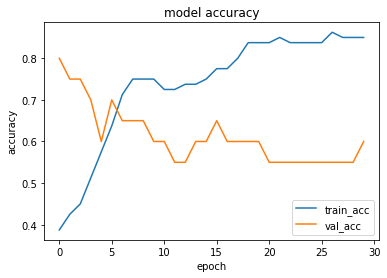

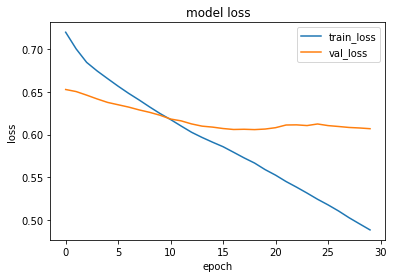

In [83]:
div_4 = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(16, return_sequences=False), 
    tf.keras.layers.Dense(1, activation="sigmoid")
])

div_4.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])
history = div_4.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 30, callbacks = [])

plot(history)

In [84]:
ensemble_val_acc([div_1, div_2, div_3, div_4], X_test, y_test)

NameError: name 'div_3' is not defined

In [88]:
new_model = tf.keras.models.load_model('85%-model-augmentations')
new_model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 184ms/step - loss: 3.3590 - accuracy: 0.7000 - precision_10: 0.6471 - recall_10: 1.0000


[3.3589541912078857, 0.699999988079071, 0.6470588445663452, 1.0]

In [89]:
for file in glob("*.mov"):
    print(f"file is {file}, prediction is {predict_on_video(new_model, file)}")

1it [00:00, 19599.55it/s]
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(
file is another_control.mov, prediction is [[0.99998784]]
1it [00:00, 18157.16it/s]
file is short_armflapping.mov, prediction is [[0.999985]]
1it [00:00, 18558.87it/s]
file is control_far.mov, prediction is [[0.99998665]]
1it [00:00, 18477.11it/s]
file is long_armflapping.mov, prediction is [[0.9999872]]
1it [00:00, 9709.04it/s]
file is me_reading_control.mov, prediction is [[0.9999876]]
1it [00:00, 16384.00it/s]file is me_armflapping.mov, prediction is [[0.9999873]]

